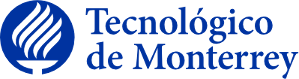

# **Maestría en Inteligencia Artificial Aplicada**

## **Proyecto Integrador - TC5035**

## Semana 4: Avance 2 - Ingeniería de características

### Profesores
- Dra. Grettel Barceló Alonso
- Dr. Luis Eduardo Falcón Morales

### Asesor
- Dr. Gerardo Jesús Camacho González

### Patrocinadores
- Dr. Jorge Antonio Ascencio Gutiérrez
- Yanmei King Loeza

### Equipo 29
- Carolina Lucas Dophe  –  A01702450
- Juan Pablo López Sánchez   –   A01313663
- Víctor Hugo Soto Herrera   –   A01706446

### Fecha de entrega
Domingo 8 de febrero de 2026

### Tabla de contenido
[Introducción](#intro)

1. [Descripción de las fuentes de datos](#fuentes)
2. [Carga de librerías y configuración inicial](#config)
3. [Desagregación temporal de la oferta productiva](#desagregacion)
4. [Exportación de conjunto de datos](#exportacion)
5. [Preparación de los datos e ingeniería de características](#ingenieria)
6. [Selección y reducción de características](#reduccion)

[Conclusiones](#conclusiones)

[Referencias](#ref)

### <a class="anchor" id="intro">Introducción</a>

El presente *notebook* tiene como objetivo documentar y ejecutar la **fase de Preparación de los Datos**, con énfasis en la **ingeniería de características (Feature Engineering)**, dentro del marco metodológico **CRISP-ML**, como paso previo al desarrollo de modelos predictivos de la oferta productiva de aguacate en el estado de Jalisco.

En un entregable previo del proyecto se llevó a cabo la integración, limpieza y análisis exploratorio de datos (EDA) a nivel anual, a partir de diversas fuentes oficiales del Servicio de Información Agroalimentaria y Pesquera (SIAP). Como resultado de dicha etapa, se construyó un conjunto de datos anual consolidado y validado, el cual constituye el punto de partida para el presente análisis.

Dado que los modelos de series de tiempo y otras técnicas de aprendizaje automático se benefician de una mayor granularidad temporal, en este notebook se implementa de manera formal un proceso de **desagregación temporal** que permite estimar una serie mensual de producción a partir de la información anual disponible. Posteriormente, se desarrollan las transformaciones y decisiones propias de la ingeniería de características, las cuales serán justificadas en función del tipo de modelos que se pretenden emplear en etapas posteriores.

### <a class="anchor" id="fuentes">1. Descripción de las fuentes de datos</a>

Si bien el presente notebook hace uso directo de un conjunto de datos ya integrado y depurado, es importante documentar las fuentes originales a partir de las cuales dicho dataset fue construido en un entregable previo del proyecto. Esto garantiza la trazabilidad metodológica y la correcta interpretación de las variables utilizadas en las etapas posteriores de análisis y modelado.

* **Dataset maestro anual de producción de aguacate en Jalisco (1980–2024)**  
  Conjunto de datos integrado y depurado como resultado del entregable previo del proyecto, construido a partir de las fuentes oficiales del SIAP descritas anteriormente. Este dataset consolida la información anual a nivel estatal, por modalidad de producción, y constituye el insumo principal para la desagregación temporal y las etapas posteriores de preparación de datos.

* **Datos Abiertos SIAP – Nivel Estado (1980–2002)** **`+`**
* **Datos Abiertos SIAP – Nivel Municipio (2003–2024)** **`+`**
* **Anuario Estadístico SIAP (1980–2024)** **`+`**

* **Indicador de comercio exterior – Importaciones mensuales de aguacate a Estados Unidos (1996–2024)**  
  Información mensual proveniente del sistema de la U.S. International Trade Commission (USITC), utilizada como indicador auxiliar para capturar la distribución temporal intra–anual de la oferta productiva. Este indicador no se emplea como medida directa del nivel de producción, sino exclusivamente para determinar participaciones relativas mensuales en el proceso de desagregación temporal.[[3](#ref3)]

**`+`** Estas fuentes fueron empleadas durante la etapa previa de integración y EDA anual, y se mencionan aquí con fines de trazabilidad metodológica. [[1](#ref1)] [[2](#ref2)]

### <a class="anchor" id="config">2. Carga de librerías y configuración inicial</a>

En esta sección se cargan las librerías necesarias para el manejo, limpieza, integración y exploración de los datos, así como algunas configuraciones básicas para facilitar la visualización y el análisis posterior.

In [1]:
# Cargar librerías
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import power_transform
from sklearn.preprocessing import OneHotEncoder

from pathlib import Path

In [2]:
# Configuración de visualización
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:,.2f}".format)

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

In [3]:
# Definición de rutas base
DATA_DIR = Path("data")
RAW_DATA_DIR = DATA_DIR / "raw"
PROCESSED_DATA_DIR = DATA_DIR / "processed"

# Definición de rutas de archivo generado en Avance 1
ANUAL_FILE = PROCESSED_DATA_DIR / "df_master_jalisco_aguacate_1980_2024.csv"

# Definición de rutas de archivo externo para hacer la estimación mensual
USITC_FILE = RAW_DATA_DIR / "usitc" / "usitc_imports_avocado_monthly.csv"

### <a class="anchor" id="desagregacion">3. Desagregación temporal de oferta productiva</a>

Esta sección presenta la metodología y el procedimiento empleados para desagregar la producción anual de aguacate a una frecuencia mensual, preservando los totales anuales y utilizando un indicador externo de mayor granularidad temporal.

#### 3.1 Motivación y justificación metodológica

La información productiva disponible para el cultivo de aguacate en el estado de Jalisco se encuentra principalmente agregada a nivel anual, lo cual limita el análisis de dinámicas intra–anuales y la aplicación de modelos de series de tiempo que se benefician de una mayor granularidad temporal. Sin embargo, el objetivo del proyecto es modelar y analizar la evolución temporal de la oferta productiva, por lo que resulta conveniente contar con una aproximación mensual de dicha variable.

Dado que no se dispone de registros oficiales de producción mensual a nivel estatal, se adopta una estrategia de desagregación temporal que permite distribuir la producción anual en una serie mensual, preservando los totales anuales originales. Esta aproximación es común en estudios económicos y agrícolas cuando existen series de baja frecuencia para la variable de interés, pero se cuenta con indicadores auxiliares de mayor frecuencia que reflejan su comportamiento temporal.

#### 3.2 Fuente del indicador

Como indicador auxiliar para la desagregación temporal se emplea información mensual de importaciones de aguacate de origen mexicano hacia Estados Unidos, obtenida del sistema de comercio internacional de la U.S. International Trade Commission (USITC)[[3](#ref3)]. Este indicador se selecciona debido a la alta correlación esperada entre los volúmenes exportados y la dinámica productiva nacional, considerando que México es el principal proveedor de aguacate al mercado estadounidense.

Si bien las importaciones reportadas no corresponden exclusivamente al estado de Jalisco, los principales estados productores y exportadores de aguacate (particularmente Jalisco y Michoacán) presentan condiciones agroclimáticas similares y ciclos productivos comparables. En este contexto, el indicador se utiliza únicamente en términos relativos, es decir, para capturar la distribución temporal mensual (% de participación por mes), y no como una medida directa del nivel de producción estatal.

#### 3.3 Metodología de desagregación temporal (Denton proporcional)

La desagregación temporal de la serie anual de producción se realiza mediante un enfoque de tipo Denton proporcional en su variante de preservación de totales, una técnica ampliamente utilizada para distribuir series de baja frecuencia en series de mayor frecuencia utilizando un indicador externo. Este método permite preservar los totales anuales observados, al mismo tiempo que incorpora la estructura temporal del indicador mensual seleccionado.

En particular, la producción anual de aguacate se distribuye a nivel mensual de acuerdo con la participación relativa de cada mes en el indicador de importaciones, garantizando que la suma de los valores mensuales reproduzca exactamente el valor anual original. Esta estrategia corresponde a una forma pragmática de temporal disaggregation using indicators, adecuada cuando el objetivo principal es obtener una aproximación consistente de la dinámica intra–anual sin introducir supuestos adicionales sobre el nivel absoluto de la variable desagregada.

#### 3.4 Construcción del dataset mensual

A partir del conjunto de datos anual consolidado, se construye un dataset de frecuencia mensual mediante la aplicación del esquema de desagregación temporal descrito en la sección anterior. Para ello, cada observación anual de producción se expande en doce registros mensuales, incorporando explícitamente la variable Mes y manteniendo las dimensiones originales del conjunto de datos, como el año y la modalidad de producción.

El proceso consiste en asignar a cada mes una fracción del volumen anual total, determinada por la participación relativa mensual del indicador externo. De esta manera, se obtiene una serie mensual de producción que reproduce exactamente los totales anuales originales y que refleja la estacionalidad implícita en el comportamiento del comercio exterior. Con fines de trazabilidad, las observaciones resultantes se identifican como datos estimados y se distingue explícitamente la frecuencia temporal de la información.

In [4]:
# Cargar datos anuales procesados
df_master_anual = pd.read_csv(ANUAL_FILE, encoding="utf-8-sig")
df_master_anual.shape

(90, 9)

In [5]:
# Mostrar las primeras filas del DataFrame
df_master_anual.head()

,Anio,Nommodalidad,Sembrada,Cosechada,Siniestrada,Volumenproduccion,Valorproduccion,Rendimiento,Precio
0,1980,Riego,"2,490.00","2,210.00",0.00,"22,100.00","442,000.00",10.00,20.00
1,1980,Temporal,760.00,675.00,0.00,"6,277.00","125,540.00",9.30,20.00
2,1981,Riego,"2,545.00","2,498.00",0.00,"24,705.00","551,366.00",9.89,22.32
3,1981,Temporal,645.00,623.00,0.00,"3,739.00","83,447.00",6.00,22.32
4,1982,Riego,"2,545.00","2,508.00",0.00,"24,964.00","617,060.00",9.95,24.72


In [6]:
# Mostrar información del DataFrame
df_master_anual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Anio               90 non-null     int64  
 1   Nommodalidad       90 non-null     object 
 2   Sembrada           90 non-null     float64
 3   Cosechada          90 non-null     float64
 4   Siniestrada        90 non-null     float64
 5   Volumenproduccion  90 non-null     float64
 6   Valorproduccion    90 non-null     float64
 7   Rendimiento        90 non-null     float64
 8   Precio             90 non-null     float64
dtypes: float64(7), int64(1), object(1)
memory usage: 6.5+ KB


In [7]:
# Cargar datos del USITC
df_indicador_raw = pd.read_csv(USITC_FILE, encoding="utf-8-sig")
df_indicador_raw.shape

(406, 6)

In [8]:
# Mostrar las primeras filas del DataFrame
df_indicador_raw.head()

,Data Type,Year,Month,Quantity Description,General First Unit of Quantity,Suppressed
0,General First Unit of Quantity,1990,4,kilograms,81,0
1,General First Unit of Quantity,1990,8,kilograms,3495,0
2,General First Unit of Quantity,1990,9,kilograms,4407,0
3,General First Unit of Quantity,1990,10,kilograms,11132,0
4,General First Unit of Quantity,1990,12,kilograms,2248,0


In [9]:
# Mostrar información del DataFrame
df_indicador_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Data Type                       406 non-null    object
 1   Year                            406 non-null    int64 
 2   Month                           406 non-null    int64 
 3   Quantity Description            406 non-null    object
 4   General First Unit of Quantity  406 non-null    int64 
 5   Suppressed                      406 non-null    int64 
dtypes: int64(4), object(2)
memory usage: 19.2+ KB


In [10]:
# Normalizar el indicador mensual para obtener participaciones relativas por año
df_indicador = (
    df_indicador_raw
    .rename(columns={
        "Year": "Anio",
        "Month": "Mes",
        "General First Unit of Quantity": "Volumen_importado"
    })
    [["Anio", "Mes", "Volumen_importado"]]
)

# Asegurar tipos
df_indicador["Anio"] = df_indicador["Anio"].astype(int)
df_indicador["Mes"] = df_indicador["Mes"].astype(int)
df_indicador["Volumen_importado"] = pd.to_numeric(
    df_indicador["Volumen_importado"],
    errors="coerce"
)

# Revisar el DataFrame final
df_indicador.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Anio               406 non-null    int64
 1   Mes                406 non-null    int64
 2   Volumen_importado  406 non-null    int64
dtypes: int64(3)
memory usage: 9.6 KB


**`NOTA`**: Debido a la cobertura mensual incompleta del indicador en los primeros años disponibles, la desagregación temporal se aplica únicamente a los años con información mensual completa. En consecuencia, el análisis mensual se realiza a partir de **`1996`**, mientras que los años previos se conservan exclusivamente a nivel anual como referencia histórica.

In [11]:
# Definir año de inicio para análisis mensual
START_YEAR_MENSUAL = 1996

df_indicador = df_indicador[df_indicador["Anio"] >= START_YEAR_MENSUAL].copy()

# Checar años con cobertura mensual completa
valid_years = (
    df_indicador
    .groupby("Anio")["Mes"]
    .nunique()
    .loc[lambda x: x == 12]
    .index
)

df_indicador = df_indicador[df_indicador["Anio"].isin(valid_years)]

In [12]:
# Cálculo de Denton Proporcional en su variante de preservación de totales para desagregar series temporales

# Calcular participación mensual por año
df_indicador["share_mes"] = (
    df_indicador
    .groupby("Anio")["Volumen_importado"]
    .transform(lambda x: x / x.sum())
)

# Validación rápida: la suma por año debe ser 1
(
    df_indicador
    .groupby("Anio")["share_mes"]
    .sum()
    .describe()
)

count   29.00
mean     1.00
std      0.00
min      1.00
25%      1.00
50%      1.00
75%      1.00
max      1.00
Name: share_mes, dtype: float64

In [13]:
# Filtrar df_master_anual para años con datos mensuales completos
df_master_anual_mensual = (
    df_master_anual
    [df_master_anual["Anio"].isin(valid_years)]
    .copy()
)

# Merge anual × mensual (por año)
df_mensual_raw = (
    df_master_anual_mensual
    .merge(
        df_indicador[["Anio", "Mes", "share_mes"]],
        on="Anio",
        how="inner"
    )
)

# Mostrar las primeras filas del DataFrame
df_mensual_raw.head()

,Anio,Nommodalidad,Sembrada,Cosechada,Siniestrada,Volumenproduccion,Valorproduccion,Rendimiento,Precio,Mes,share_mes
0,1996,Riego,982.00,555.00,0.00,"6,106.00","10,117,642.00",11.00,"1,657.00",1,0.06
1,1996,Riego,982.00,555.00,0.00,"6,106.00","10,117,642.00",11.00,"1,657.00",2,0.07
2,1996,Riego,982.00,555.00,0.00,"6,106.00","10,117,642.00",11.00,"1,657.00",3,0.09
3,1996,Riego,982.00,555.00,0.00,"6,106.00","10,117,642.00",11.00,"1,657.00",4,0.10
4,1996,Riego,982.00,555.00,0.00,"6,106.00","10,117,642.00",11.00,"1,657.00",5,0.12


In [14]:
# Deasignación mensual de las variables anuales
df_mensual_raw["Volumenproduccion"] = (
    df_mensual_raw["Volumenproduccion"] * df_mensual_raw["share_mes"]
)

In [15]:
# 
df_mensual_raw["Frecuencia"] = "Mensual"
df_mensual_raw["TipoDato"] = "Estimado"

# Ordenar para legibilidad
df_master_mensual = df_mensual_raw.sort_values(
    ["Anio", "Mes", "Nommodalidad"]
).reset_index(drop=True)

df_master_mensual.head(12)

,Anio,Nommodalidad,Sembrada,Cosechada,Siniestrada,Volumenproduccion,Valorproduccion,Rendimiento,Precio,Mes,share_mes,Frecuencia,TipoDato
0,1996,Riego,982.00,555.00,0.00,360.67,"10,117,642.00",11.00,"1,657.00",1,0.06,Mensual,Estimado
1,1996,Temporal,58.00,58.00,0.00,25.34,"710,853.00",7.40,"1,657.00",1,0.06,Mensual,Estimado
2,1996,Riego,982.00,555.00,0.00,447.64,"10,117,642.00",11.00,"1,657.00",2,0.07,Mensual,Estimado
3,1996,Temporal,58.00,58.00,0.00,31.45,"710,853.00",7.40,"1,657.00",2,0.07,Mensual,Estimado
4,1996,Riego,982.00,555.00,0.00,566.33,"10,117,642.00",11.00,"1,657.00",3,0.09,Mensual,Estimado
5,1996,Temporal,58.00,58.00,0.00,39.79,"710,853.00",7.40,"1,657.00",3,0.09,Mensual,Estimado
6,1996,Riego,982.00,555.00,0.00,594.51,"10,117,642.00",11.00,"1,657.00",4,0.10,Mensual,Estimado
7,1996,Temporal,58.00,58.00,0.00,41.77,"710,853.00",7.40,"1,657.00",4,0.10,Mensual,Estimado
8,1996,Riego,982.00,555.00,0.00,712.07,"10,117,642.00",11.00,"1,657.00",5,0.12,Mensual,Estimado
9,1996,Temporal,58.00,58.00,0.00,50.03,"710,853.00",7.40,"1,657.00",5,0.12,Mensual,Estimado


In [16]:
# Reagregar mensual -> anual
check_totals = (
    df_master_mensual
    .groupby(["Anio", "Nommodalidad"], as_index=False)["Volumenproduccion"]
    .sum()
    .merge(
        df_master_anual_mensual,
        on=["Anio", "Nommodalidad"],
        suffixes=("_mensual", "_anual")
    )
)

check_totals["diff"] = (
    check_totals["Volumenproduccion_mensual"]
    - check_totals["Volumenproduccion_anual"]
)

check_totals["diff"].describe()

count   58.00
mean     0.00
std      0.00
min      0.00
25%      0.00
50%      0.00
75%      0.00
max      0.00
Name: diff, dtype: float64

In [17]:
# Verificar información del DataFrame final
df_master_mensual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Anio               696 non-null    int64  
 1   Nommodalidad       696 non-null    object 
 2   Sembrada           696 non-null    float64
 3   Cosechada          696 non-null    float64
 4   Siniestrada        696 non-null    float64
 5   Volumenproduccion  696 non-null    float64
 6   Valorproduccion    696 non-null    float64
 7   Rendimiento        696 non-null    float64
 8   Precio             696 non-null    float64
 9   Mes                696 non-null    int64  
 10  share_mes          696 non-null    float64
 11  Frecuencia         696 non-null    object 
 12  TipoDato           696 non-null    object 
dtypes: float64(8), int64(2), object(3)
memory usage: 70.8+ KB


**`NOTA`**: La serie mensual obtenida mediante este procedimiento debe interpretarse como una aproximación estimada de la dinámica temporal de la producción, utilizada con fines analíticos y de modelado, y no como una medición directa de producción observada a nivel mensual.

#### 3.5 Validaciones y consistencia temporal

En esta sección se realizan validaciones cuantitativas y visuales para verificar la consistencia, coherencia y calidad de la serie mensual estimada a partir del proceso de desagregación temporal.

##### Preservación de totales anuales

Se verifica que la agregación de la serie mensual reproduzca exactamente los valores anuales originales de producción, condición fundamental del método de desagregación empleado.

In [18]:
# Agregar mensual -> anual
df_mensual_agregado = (
    df_master_mensual
    .groupby("Anio", as_index=False)["Volumenproduccion"]
    .sum()
    .rename(columns={"Volumenproduccion": "Volumen_mensual_agregado"})
)

# Filtrar anual al mismo rango temporal
df_anual_comp = (
    df_master_anual
    [df_master_anual["Anio"] >= 1996]
    .groupby("Anio", as_index=False)["Volumenproduccion"]
    .sum()
    .rename(columns={"Volumenproduccion": "Volumen_anual_observado"})
)

# Unir para comparación
df_check = df_anual_comp.merge(
    df_mensual_agregado,
    on="Anio",
    how="inner"
)

df_check.head()

,Anio,Volumen_anual_observado,Volumen_mensual_agregado
0,1996,"6,535.00","6,535.00"
1,1997,"6,739.00","6,739.00"
2,1998,"4,985.00","4,985.00"
3,1999,"5,565.00","5,565.00"
4,2000,"5,213.00","5,213.00"


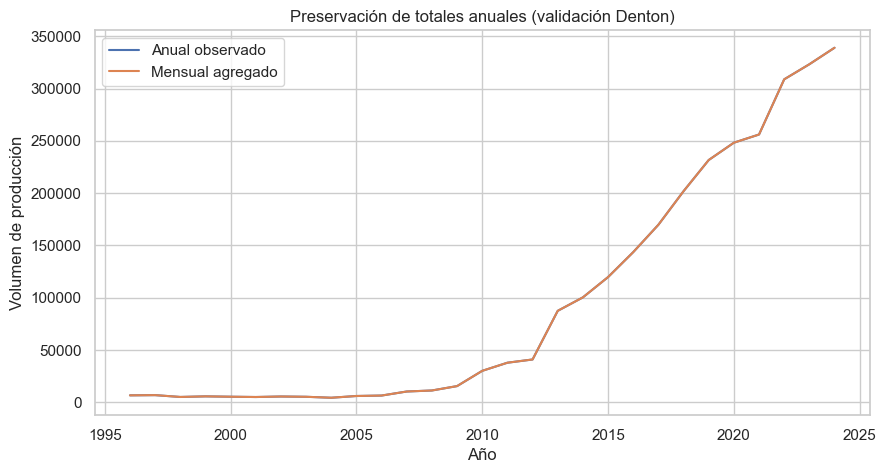

In [19]:
# Gráfica de validación
plt.figure()
plt.plot(df_check["Anio"], df_check["Volumen_anual_observado"], label="Anual observado")
plt.plot(df_check["Anio"], df_check["Volumen_mensual_agregado"], label="Mensual agregado")
plt.xlabel("Año")
plt.ylabel("Volumen de producción")
plt.title("Preservación de totales anuales (validación Denton)")
plt.legend()
plt.show()

##### Estacionalidad mensual promedio

Se analiza la distribución promedio de la producción a lo largo del año con el fin de identificar patrones estacionales implícitos y validar que la estructura temporal resultante sea razonable.

In [20]:
# Calcular estacionalidad promedio
df_estacionalidad = (
    df_master_mensual
    .groupby("Mes", as_index=False)["share_mes"]
    .mean()
)

df_estacionalidad

,Mes,share_mes
0,1,0.13
1,2,0.10
2,3,0.10
3,4,0.09
4,5,0.06
5,6,0.05
6,7,0.04
7,8,0.05
8,9,0.06
9,10,0.08


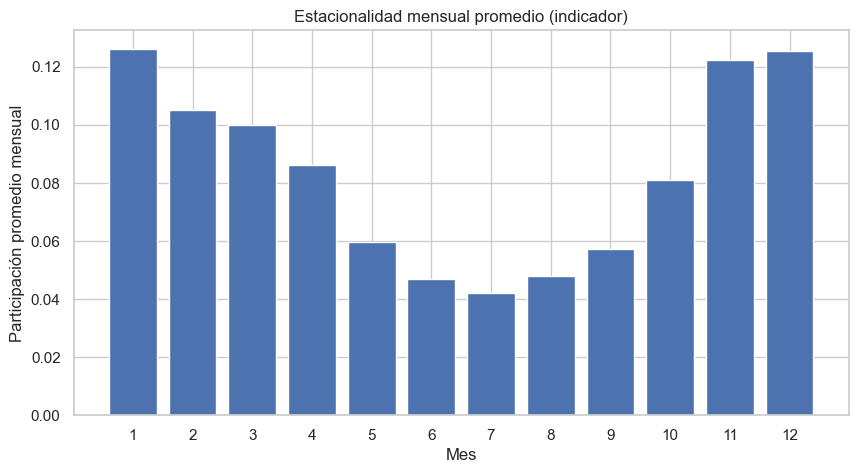

In [21]:
# Gráfica de estacionalidad mensual promedio
plt.figure()
plt.bar(df_estacionalidad["Mes"], df_estacionalidad["share_mes"])
plt.xlabel("Mes")
plt.ylabel("Participación promedio mensual")
plt.title("Estacionalidad mensual promedio (indicador)")
plt.xticks(range(1, 13))
plt.show()

##### Revisión visual de la serie mensual completa

Se examina la serie mensual completa mediante visualización gráfica para detectar posibles discontinuidades, valores atípicos o comportamientos anómalos derivados del proceso de estimación.

In [22]:
# Crear columna de fecha para graficar
df_master_mensual["Fecha"] = pd.to_datetime(
    dict(year=df_master_mensual["Anio"], month=df_master_mensual["Mes"], day=1)
)

# Agregar por mes (si hay modalidad)
df_mensual_total = (
    df_master_mensual
    .groupby("Fecha", as_index=False)["Volumenproduccion"]
    .sum()
)

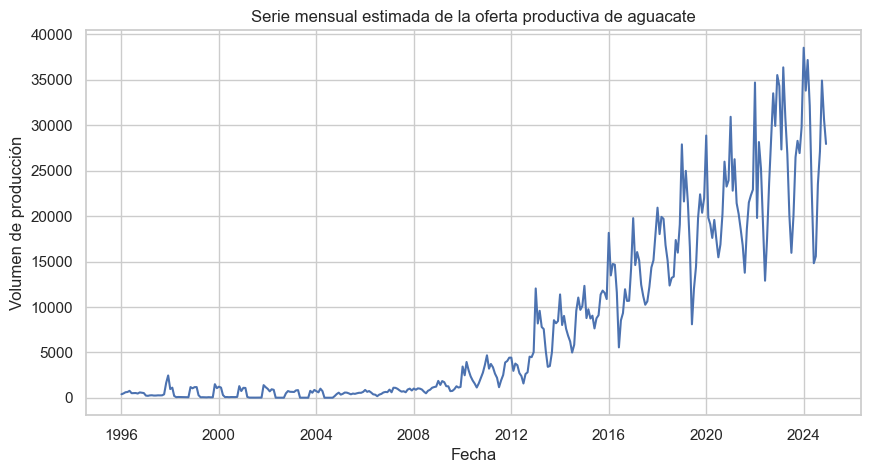

In [23]:
# Gráfica de la serie mensual estimada
plt.figure()
plt.plot(df_mensual_total["Fecha"], df_mensual_total["Volumenproduccion"])
plt.xlabel("Fecha")
plt.ylabel("Volumen de producción")
plt.title("Serie mensual estimada de la oferta productiva de aguacate")
plt.show()

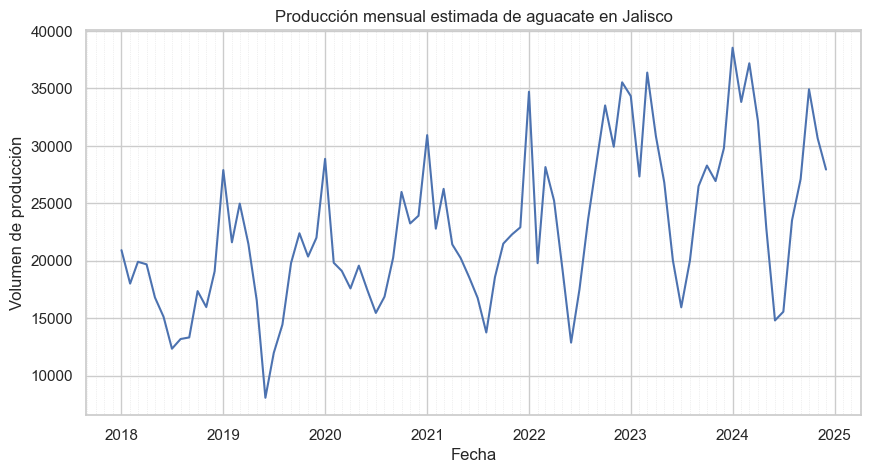

In [24]:
import matplotlib.dates as mdates

# Ordenar por fecha (seguridad)
df_mensual_total_zoom = df_mensual_total.sort_values("Fecha")[df_mensual_total["Fecha"] >= "2018-01-01"]

# Graficar zoom a partir de 2018
plt.figure()
plt.plot(df_mensual_total_zoom["Fecha"],
         df_mensual_total_zoom["Volumenproduccion"])

ax = plt.gca()

# Ticks menores: cada mes
ax.xaxis.set_minor_locator(mdates.MonthLocator())

# Ticks mayores: cada año (en diciembre)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.title("Producción mensual estimada de aguacate en Jalisco")
plt.xlabel("Fecha")
plt.ylabel("Volumen de producción")

# Grilla diferenciada
ax.grid(True, which='major', linewidth=1.0)
ax.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.6)

plt.show()

### <a class="anchor" id="exportacion">4. Exportación de conjunto de datos</a>

Una vez concluida la etapa de integración y homologación de datos, el conjunto de datos resultante se exporta para su reutilización en las etapas posteriores de análisis exploratorio, ingeniería de características y modelado.

In [25]:
# Guardar DataFrame mensual maestro a CSV
df_master_mensual.to_csv(
    PROCESSED_DATA_DIR / "df_master_estimacion_mensual_jalisco_aguacate_1996_2024.csv",
    index=False
)

### <a class="anchor" id="ingenieria">5. Preparación de los datos e ingeniería de características</a>

En esta sección se documentan las decisiones metodológicas orientadas a transformar el conjunto de datos mensual en una representación adecuada para el modelado predictivo, incluyendo la depuración de variables, la generación de nuevas características y la aplicación de transformaciones estadísticas. El objetivo es mejorar la calidad, interpretabilidad y utilidad del dataset sin introducir sesgos o filtraciones de información hacia la variable objetivo.

#### 5.1 Revisión estructural del dataset mensual

Se realiza una inspección general de la estructura del conjunto de datos mensual, incluyendo tipos de variables, dimensiones, frecuencia temporal y consistencia interna, con el fin de identificar diferencias relevantes respecto al dataset anual y establecer una base clara para las transformaciones posteriores.

In [26]:
# Vista inicial del dataset mensual
df = pd.read_csv(PROCESSED_DATA_DIR / "df_master_estimacion_mensual_jalisco_aguacate_1996_2024.csv")
df.head()

,Anio,Nommodalidad,Sembrada,Cosechada,Siniestrada,Volumenproduccion,Valorproduccion,Rendimiento,Precio,Mes,share_mes,Frecuencia,TipoDato,Fecha
0,1996,Riego,982.00,555.00,0.00,360.67,"10,117,642.00",11.00,"1,657.00",1,0.06,Mensual,Estimado,1996-01-01
1,1996,Temporal,58.00,58.00,0.00,25.34,"710,853.00",7.40,"1,657.00",1,0.06,Mensual,Estimado,1996-01-01
2,1996,Riego,982.00,555.00,0.00,447.64,"10,117,642.00",11.00,"1,657.00",2,0.07,Mensual,Estimado,1996-02-01
3,1996,Temporal,58.00,58.00,0.00,31.45,"710,853.00",7.40,"1,657.00",2,0.07,Mensual,Estimado,1996-02-01
4,1996,Riego,982.00,555.00,0.00,566.33,"10,117,642.00",11.00,"1,657.00",3,0.09,Mensual,Estimado,1996-03-01


In [27]:
# Porcentaje de valores faltantes
num_rows = df.shape[0]
print("Valores nulos:\n")

for col in df.columns:
    na = ((df[col].notna().count() - num_rows) * 100) / num_rows
    print(f'{col}: {na}')

Valores nulos:

Anio: 0.0
Nommodalidad: 0.0
Sembrada: 0.0
Cosechada: 0.0
Siniestrada: 0.0
Volumenproduccion: 0.0
Valorproduccion: 0.0
Rendimiento: 0.0
Precio: 0.0
Mes: 0.0
share_mes: 0.0
Frecuencia: 0.0
TipoDato: 0.0
Fecha: 0.0


Para este dataset no se cuentan con datos faltantes en ninguna columna, lo cual es de mucha ayuda para ahorrarnos el proceso de imputar datos o deshacernos de columnas severamente dañadas.

In [28]:
# Información estructural del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Anio               696 non-null    int64  
 1   Nommodalidad       696 non-null    object 
 2   Sembrada           696 non-null    float64
 3   Cosechada          696 non-null    float64
 4   Siniestrada        696 non-null    float64
 5   Volumenproduccion  696 non-null    float64
 6   Valorproduccion    696 non-null    float64
 7   Rendimiento        696 non-null    float64
 8   Precio             696 non-null    float64
 9   Mes                696 non-null    int64  
 10  share_mes          696 non-null    float64
 11  Frecuencia         696 non-null    object 
 12  TipoDato           696 non-null    object 
 13  Fecha              696 non-null    object 
dtypes: float64(8), int64(2), object(4)
memory usage: 76.3+ KB


En nuestro dataset se puede observar que en su mayoría está compuesto por variables numéricas, siendo `Anio` y `Mes`, las únicas columnas con valores numéricos enteros, mientras que el resto son valores con decimales. La columna `Nommodalidad` es la principal variable categórica del conjunto de datos, acompañada por variables descriptivas adicionales como `Frecuencia` y `TipoDato`.

In [29]:
# Estadísticas descriptivas de variables numéricas
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Anio,696.00,"2,010.00",8.37,"1,996.00","2,003.00","2,010.00","2,017.00","2,024.00"
Sembrada,696.00,"5,607.68","7,542.26",55.00,540.00,"3,186.27","5,479.01","27,627.94"
Cosechada,696.00,"4,334.14","6,541.05",55.00,438.50,"1,624.62","3,559.33","25,634.31"
Siniestrada,696.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Volumenproduccion,696.00,"3,930.35","6,828.98",0.65,238.08,"1,017.17","2,822.03","35,712.53"
Valorproduccion,696.00,"956,226,081.55","1,970,385,796.65","710,853.00","18,447,600.36","129,217,576.81","652,205,681.80","8,580,088,223.56"
Rendimiento,696.00,9.29,1.66,5.33,8.27,9.19,10.26,12.38
Precio,696.00,"12,050.84","7,354.58","1,657.00","5,885.34","11,214.66","16,145.98","32,102.94"
Mes,696.00,6.50,3.45,1.00,3.75,6.50,9.25,12.00
share_mes,696.00,0.08,0.05,0.00,0.06,0.08,0.10,0.36


En las estadísticas generales de las variables numéricas, se puede observar que la variable `Siniestrada` solo tiene valores de 0, ya que tanto su mínimo como su máximo tienen el mismo valor de 0, lo que indica que en nuestro dataset no existen registros que contemplen cantidad de territorio dañado. Por esto mismo es que se eliminará esta variable por no aportar ningún valor a nuestro dataset.

Eso lo haremos en la siguiente sección.

#### 5.2 Selección y depuración de variables

En esta etapa se realiza la selección y depuración de variables con el objetivo de conservar únicamente aquellas características que aportan información relevante para el modelado de la oferta productiva, evitando redundancias y posibles fugas de información hacia la variable objetivo.

Dado que el objetivo del proyecto es estimar el volumen de producción, se eliminan variables monetarias y derivadas que podrían introducir dependencia directa con la variable objetivo o no ser observables de forma exógena en un escenario real de predicción. Asimismo, se descartan variables administrativas o descriptivas que no aportan valor explicativo al proceso de modelado.

**Variables a eliminar:**

* `Valorproduccion`
  * Derivada directamente de `Volumenproduccion × Precio`.
* `Precio`
  * Variable monetaria, no determinante directa de la oferta física.
* `Siniestrada`
  * No presenta variabilidad (siempre es cero).
* `TipoDato`, `Frecuencia`
  * Metadatos del proceso de construcción del dataset.
* `share_mes`
  * Variable instrumental usada solo para la desagregación temporal.
* ~~`Fecha`~~
  * ~~Puede reconstruirse a partir de `Anio` y `Mes`.~~

La selección se realiza antes de cualquier transformación para evitar propagar ruido o dependencia a etapas posteriores.

In [30]:
# Copia del dataset para features engineering
df_fe = df.copy()

# Variables a eliminar
cols_to_drop = [
    "Valorproduccion",
    "Precio",
    "Siniestrada",
    "TipoDato",
    "Frecuencia",
    "share_mes",
    #"Fecha"
]

# Eliminar columnas existentes
df_fe = df_fe.drop(columns=[c for c in cols_to_drop if c in df_fe.columns], errors="ignore")

df_fe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Anio               696 non-null    int64  
 1   Nommodalidad       696 non-null    object 
 2   Sembrada           696 non-null    float64
 3   Cosechada          696 non-null    float64
 4   Volumenproduccion  696 non-null    float64
 5   Rendimiento        696 non-null    float64
 6   Mes                696 non-null    int64  
 7   Fecha              696 non-null    object 
dtypes: float64(4), int64(2), object(2)
memory usage: 43.6+ KB


**Recuperación de columna 'Fecha' y asignación como índice**

De acuerdo a lo aprendido en el `Avance 3` decidimos recuperar la variable 'Fecha', previamente eliminada y usarla como índice.

In [31]:
# Recuperación de Fecha
df_fe["Fecha"] = pd.to_datetime(df_fe["Fecha"])
df_fe = df_fe.set_index(["Fecha"])

Tras la depuración, el conjunto de datos conserva únicamente variables productivas, temporales y categóricas directamente relacionadas con la dinámica de la oferta, reduciendo el riesgo de fuga de información y mejorando la interpretabilidad y robustez de los modelos a implementar.

Estas decisiones se alinean con un escenario realista de predicción, donde variables monetarias o agregadas ex post no estarían disponibles al momento de estimar la producción futura.


#### 5.3 Discretización o binning


Debido a que la discretización implica la transformación de variables continuas en categorías, y considerando que el objetivo del proyecto es predecir la oferta productiva de aguacate mediante una solución de tipo regresión, no se consideró apropiado aplicar técnicas de discretización o binning sobre las variables numéricas.

Por otro lado, la discreción requiere la definición de criterios claros que justifiquen la creación de subgrupos, y en este caso, no se identificaron motivos adecuados que respalden la discretización de las variables numéricas.

Adicionalmente, en secciones posteriores se llevarán a cabo procesos de transformación, normalización y codificación, los cuales están orientados en mantener las variables numéricas y facilitar su uso en modelos de regresión y análisis temporal. Por lo anterior, se decidió conservar las variables en su forma numérica continua, descartando la aplicación de técnicas de binning en esta etapa del preprocesamiento.

#### 5.4 Tranformaciones de variables numéricas

Se aplican transformaciones estadísticas a las variables numéricas con el fin de reducir asimetrías, estabilizar la varianza y facilitar el aprendizaje de los modelos, retomando criterios identificados en el análisis exploratorio previo y adaptándolos al contexto de la serie mensual estimada.

Como paso inicial, se comenzará con identificar variables con valores atípicos, para en su debido caso eliminarlos y así evitar aplicarle transformaciones construidas a partir de outliers a las variables. Cabe resaltar que variables como `Anio` y `Mes`, a pesar de ser técnicamente numéricas, estas se comportan como categóricas, por lo que no pueden ser contempladas para identificación de outliers ni para cálculo de asimetría.

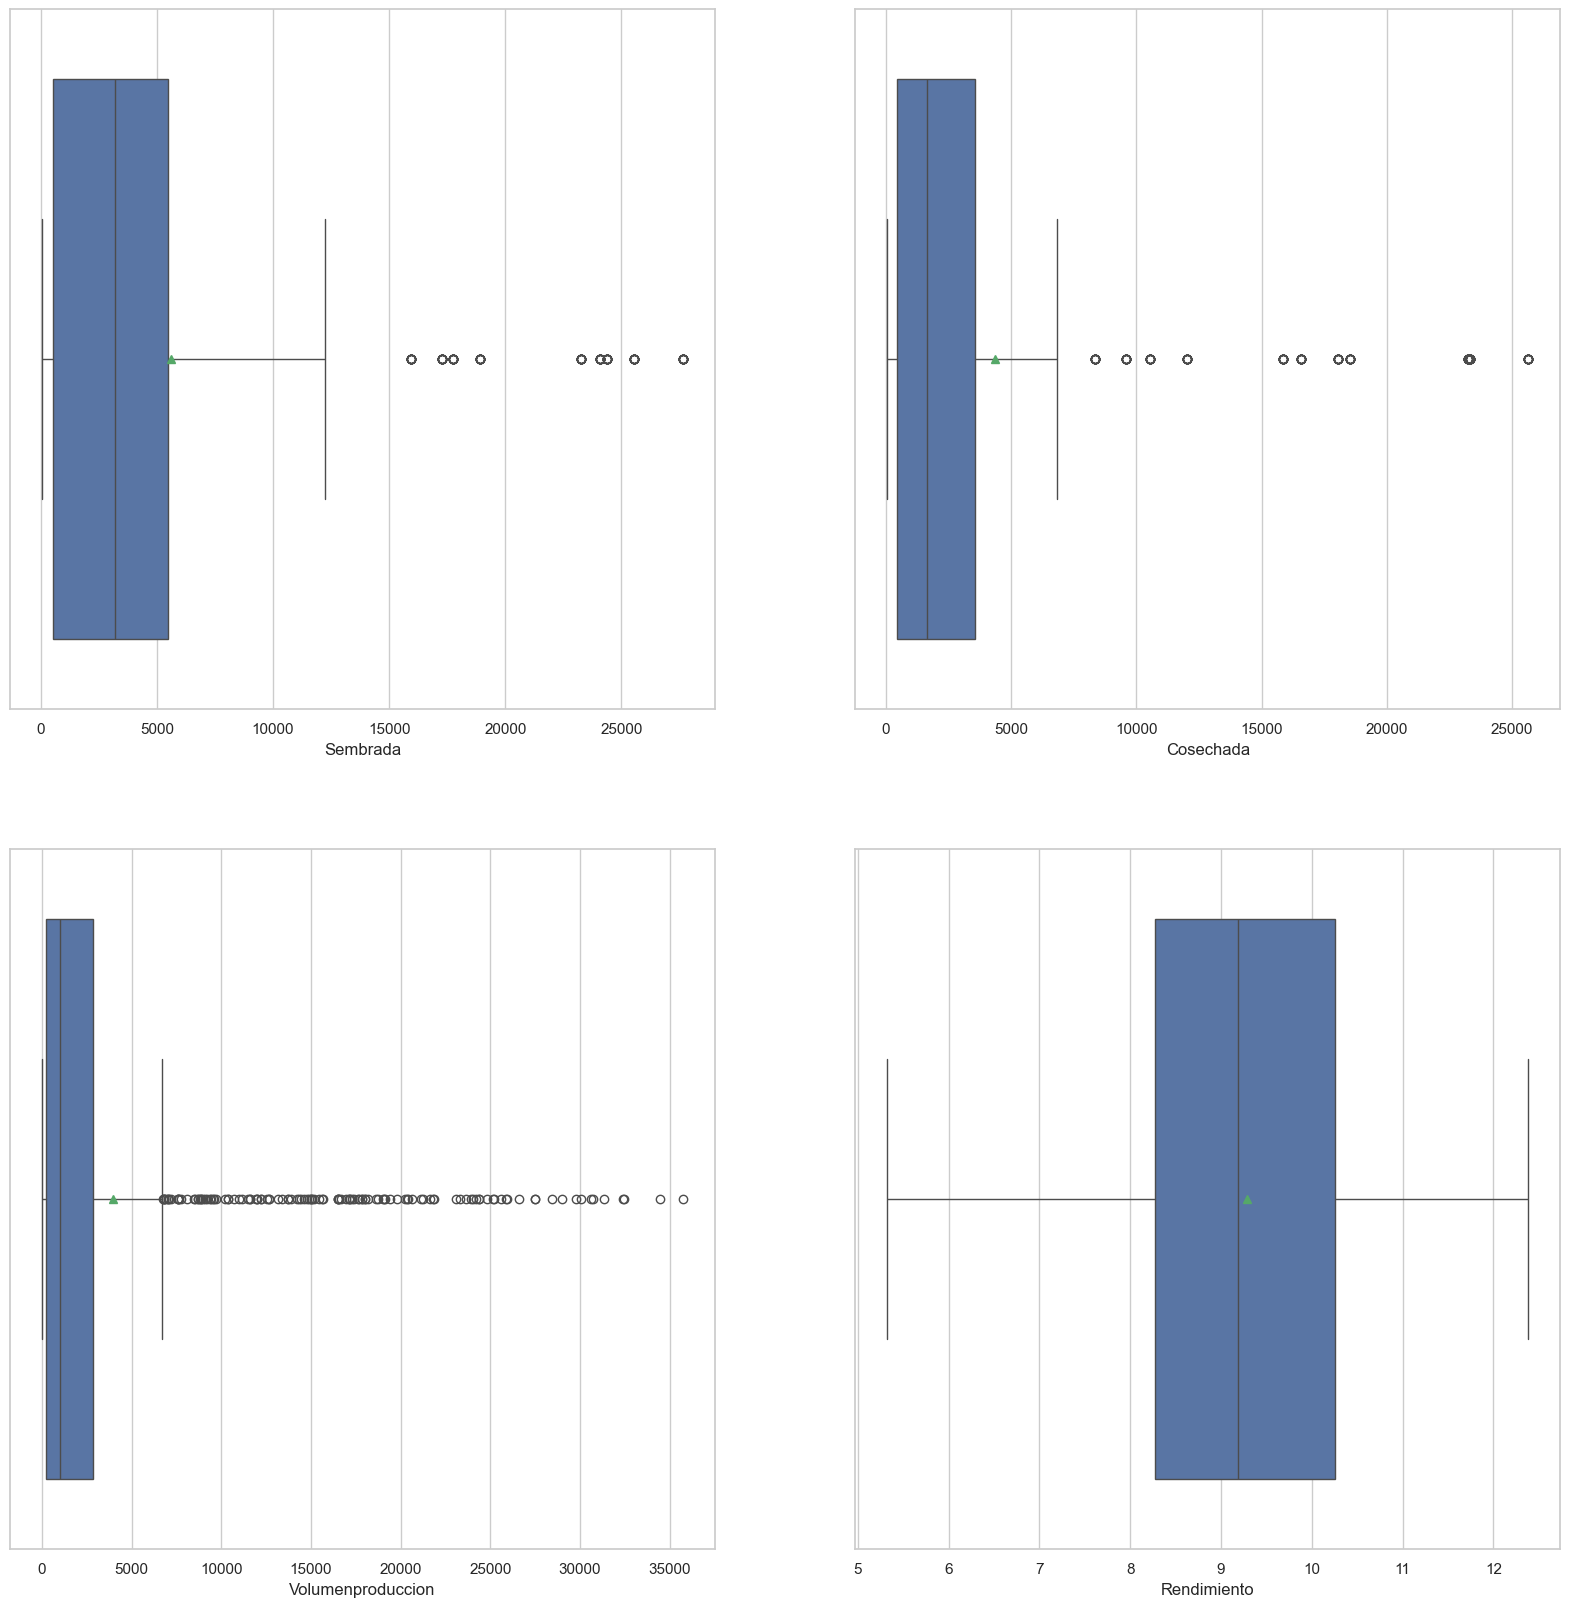

In [32]:
# Graficar matriz de box plots para demostrar valores atípicos
num_cols = ['Sembrada', 'Cosechada', 'Volumenproduccion', 'Rendimiento']
figure, axes = plt.subplots(2, 2, figsize = (20, 20))
axes = axes.ravel()

for col, ax in zip(num_cols, axes):
    sns.boxplot(x = df_fe[col], ax = ax, showmeans = True)
    ax.set(xlabel = f'{col}')

A partir de los Box Plots graficados para cada columna numérica se puede observar que la columna `Rendimiento` es la única variable numérica que no contiene valores atípicos.

Ahora con la confirmación de la existencia de valores atípicos en las variables `Sembrada`, `Cosechada` y `Volumenproduccion`, se procederá a identificar en el dataset los registros que son atípicos y luego se eliminarán.

In [33]:
# Identificación de valores atípicos y su eliminación del dataset
outlier_cols = ['Sembrada', 'Cosechada', 'Volumenproduccion']

for col in outlier_cols:
    q1 = df_fe[col].quantile(0.25)
    q3 = df_fe[col].quantile(0.75)
    iqr = q3 - q1

    upper_cap = q3 + 1.5 * iqr
    lower_cap = q1 - 1.5 * iqr

    outliers = df_fe[(df_fe[col] > upper_cap) | (df_fe[col] < lower_cap)][col]

    df_fe = df_fe[~df_fe[col].isin(outliers)]

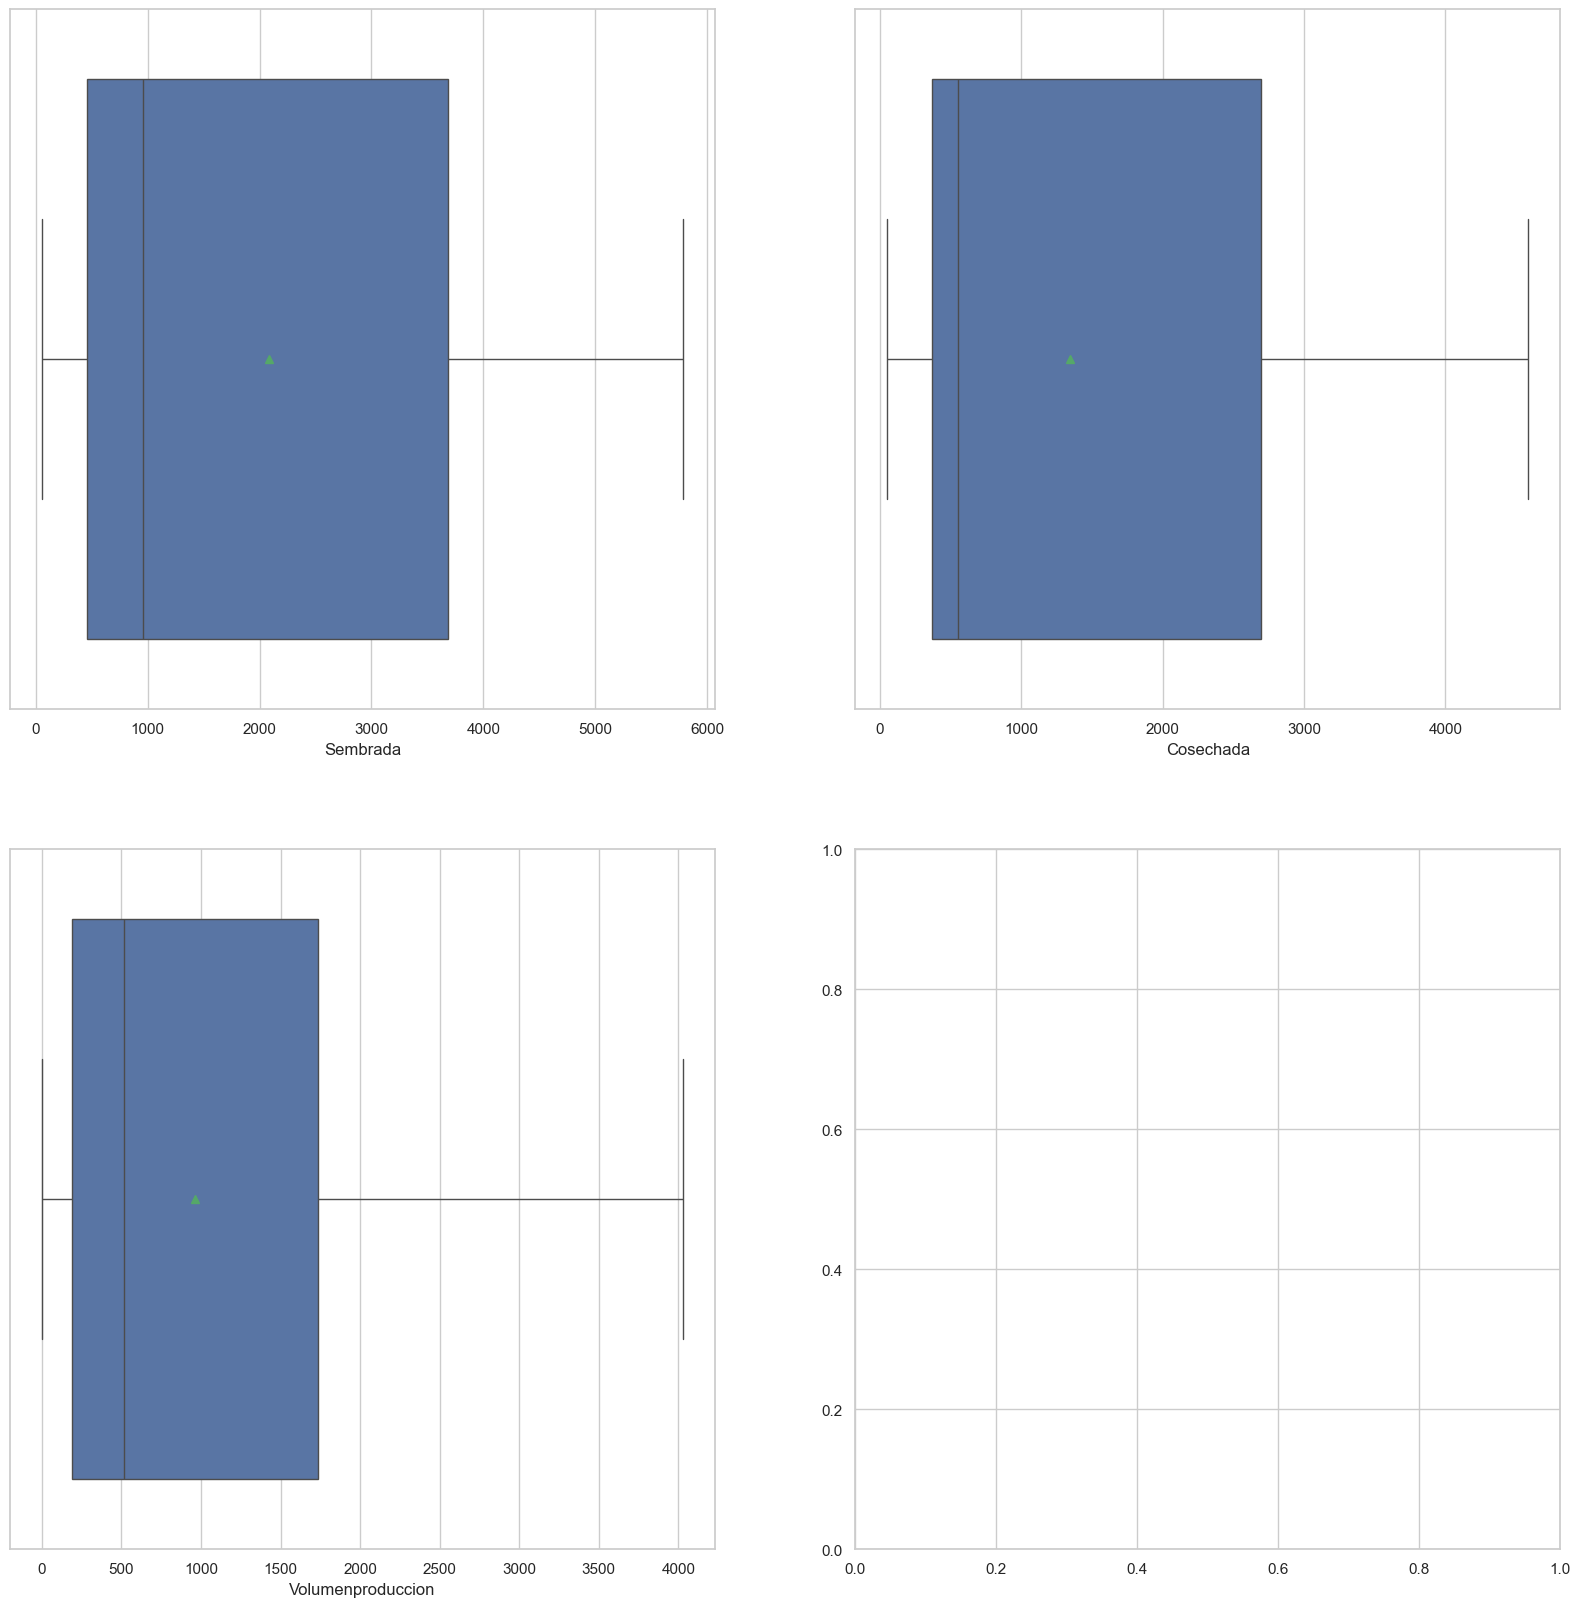

In [34]:
# Graficar matriz de box plots con el nuevo dataset limpio
figure, axes = plt.subplots(2, 2, figsize = (20,20))
axes = axes.ravel()

for col, ax in zip(outlier_cols, axes):
    sns.boxplot(x = df_fe[col], ax = ax, showmeans = True)
    ax.set(xlabel = f'{col}')

Al eliminar los outliers que se habían identificado previamente, podemos ver gráficas de Box Plots más limpias ahora. Particularmente, las variables `Sembrada`, `Cosechada` y `Volumenproduccion` ya no presentan valores atípicos.

Teniendo ahora todas las variables libres de outliers, se puede proceder a analizar la asimetría de la distribución de los datos de cada variable, para contemplar la necesidad de aplicar alguna transformación para que la distribución de los datos no introduzca alguna especie de sesgo, para cuando se empleen para la alimentación de un modelo de aprendizaje automático.

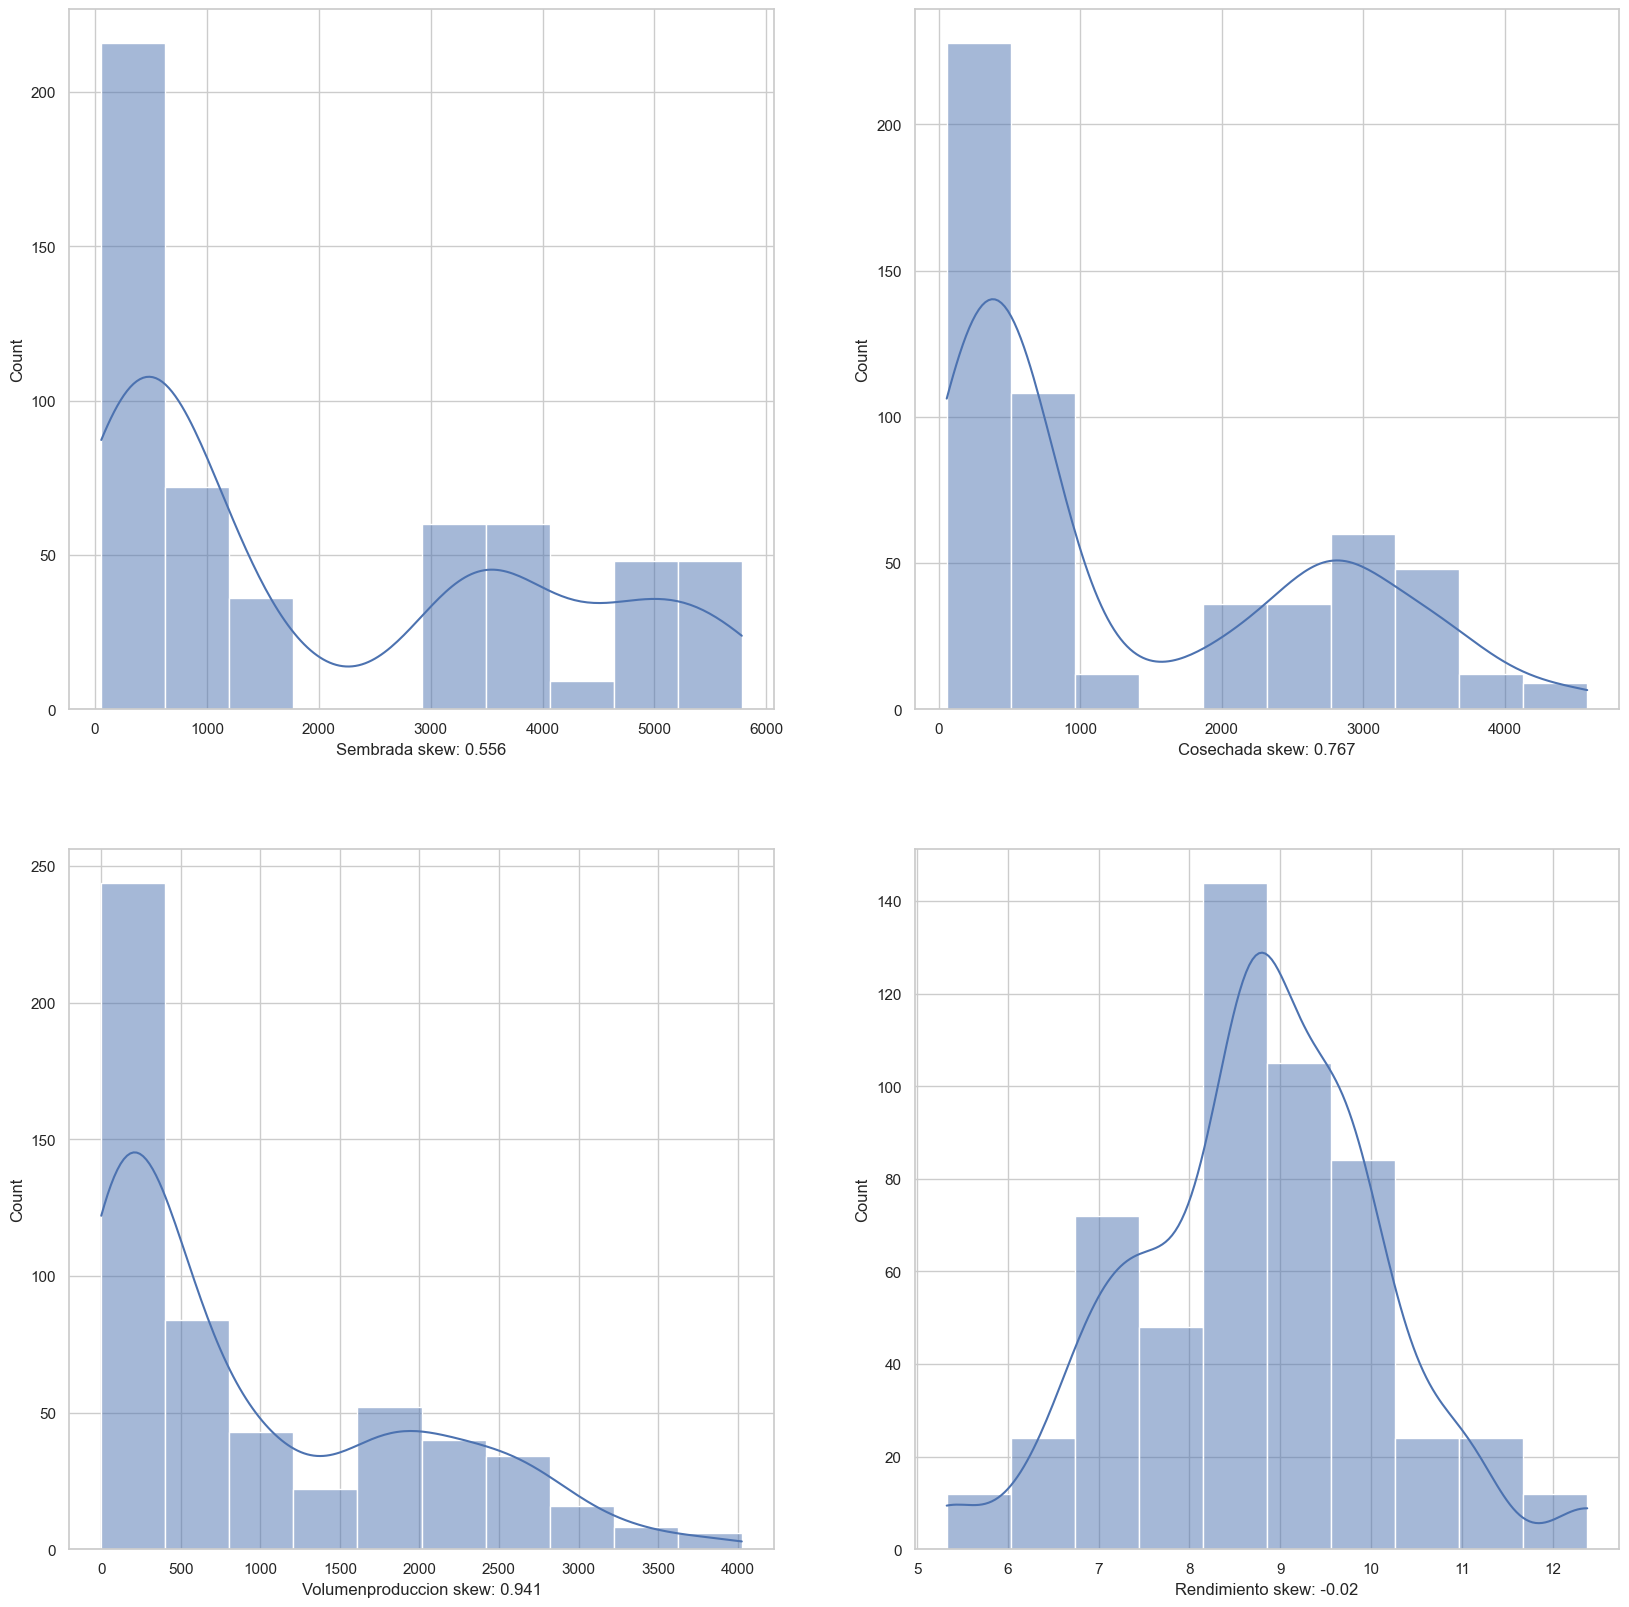

In [35]:
# Graficar matriz de histogramas para demostrar distribuciones de los datos
figure, axis = plt.subplots(2, 2, figsize = (20, 20))
axis = axis.ravel()

for col, ax in zip(num_cols, axis):
    skew = round(df_fe[col].skew(), 3)
    sns.histplot(x = df_fe[col], bins = 10, kde = True, ax = ax)
    ax.set(xlabel = f'{col} skew: {skew}')

Como resultado de la validación estructural de los datos, se puede observar que hay una inconsistencia que puede llegar a afectar el rendimiento de los modelos que se vayan a emplear, y es que se tienen datos únicos pero que corresponden a un mismo instante. Este hecho si bien puede no romper los modelos que trabajen con series de tiempo, si pueden afectar su rendimiento, porque teóricamente una serie de tiempo contiene registros únicos por cada instante en el tiempo, no se puede tener un instante en el tiempo con varios registros, porque los modelos esperan datasets de series de tiempo en donde cada registro nuevo es más reciente que el anterior.

Para arreglar este detalle en el dataset, se encontró que la razón de que haya instantes en el tiempo con diversos registros es la columna de `Nommodalidad_one_hot` porque se están separando el registro de los datos por la categoría de esa variable en un mismo instante. Por lo que se decidió sumar todos los datos que correspondan en un mismo instante en el tiempo para tener registros de instantes únicos, y como conseciencia se elimina la variable del dataset.

In [36]:
# Regresar el índice como columna en el dataset
df_fe = df_fe.reset_index()

# Sumar únicamente las variables numéricas que representan cantidad (Sembrada, Cosechada, Rendimiento) y no que se comportan como categóricas
df_fe = df_fe.groupby(by = ["Fecha", "Anio", "Mes"], as_index = False)[["Sembrada", "Cosechada", "Rendimiento", "Volumenproduccion"]].sum()

# Regresar la columna fecha como índice
df_fe = df_fe.set_index(["Fecha"])
df_fe.head(20)

,Anio,Mes,Sembrada,Cosechada,Rendimiento,Volumenproduccion
Fecha,,,,,,
1996-01-01,1996,1,"1,040.00",613.00,18.40,386.01
1996-02-01,1996,2,"1,040.00",613.00,18.40,479.09
1996-03-01,1996,3,"1,040.00",613.00,18.40,606.12
1996-04-01,1996,4,"1,040.00",613.00,18.40,636.28
1996-05-01,1996,5,"1,040.00",613.00,18.40,762.10
1996-06-01,1996,6,"1,040.00",613.00,18.40,504.28
1996-07-01,1996,7,"1,040.00",613.00,18.40,512.69
1996-08-01,1996,8,"1,040.00",613.00,18.40,522.85
1996-09-01,1996,9,"1,040.00",613.00,18.40,466.24


En cuanto a los histogramas obtenidos por cada variable numérica, se puede destacar que la variable `Rendimiento` es la única columna que prácticamente no tiene asimetría, se puede observar en su propio histograma al observar que la distribución de los datos tiene una forma Gaussiana, y además porque numéricamente su asimetría es muy cercana a cero.

No obstante, el resto de las variables presentan asimetría positiva, primeramente porque todos sus datos se encuentran alineados a la izquierda en su gráfica de histograma, y porque su valor numérico es mayor a cero.

A estas variables con asimetría positiva se decidió aplicarles una transformación 'Box-Cox' ya que todos los valores presentes en cada columna son positivos, y además este método es una transformación más robusta que aplicar una transformación de raíz cuadrada o logarítmica.

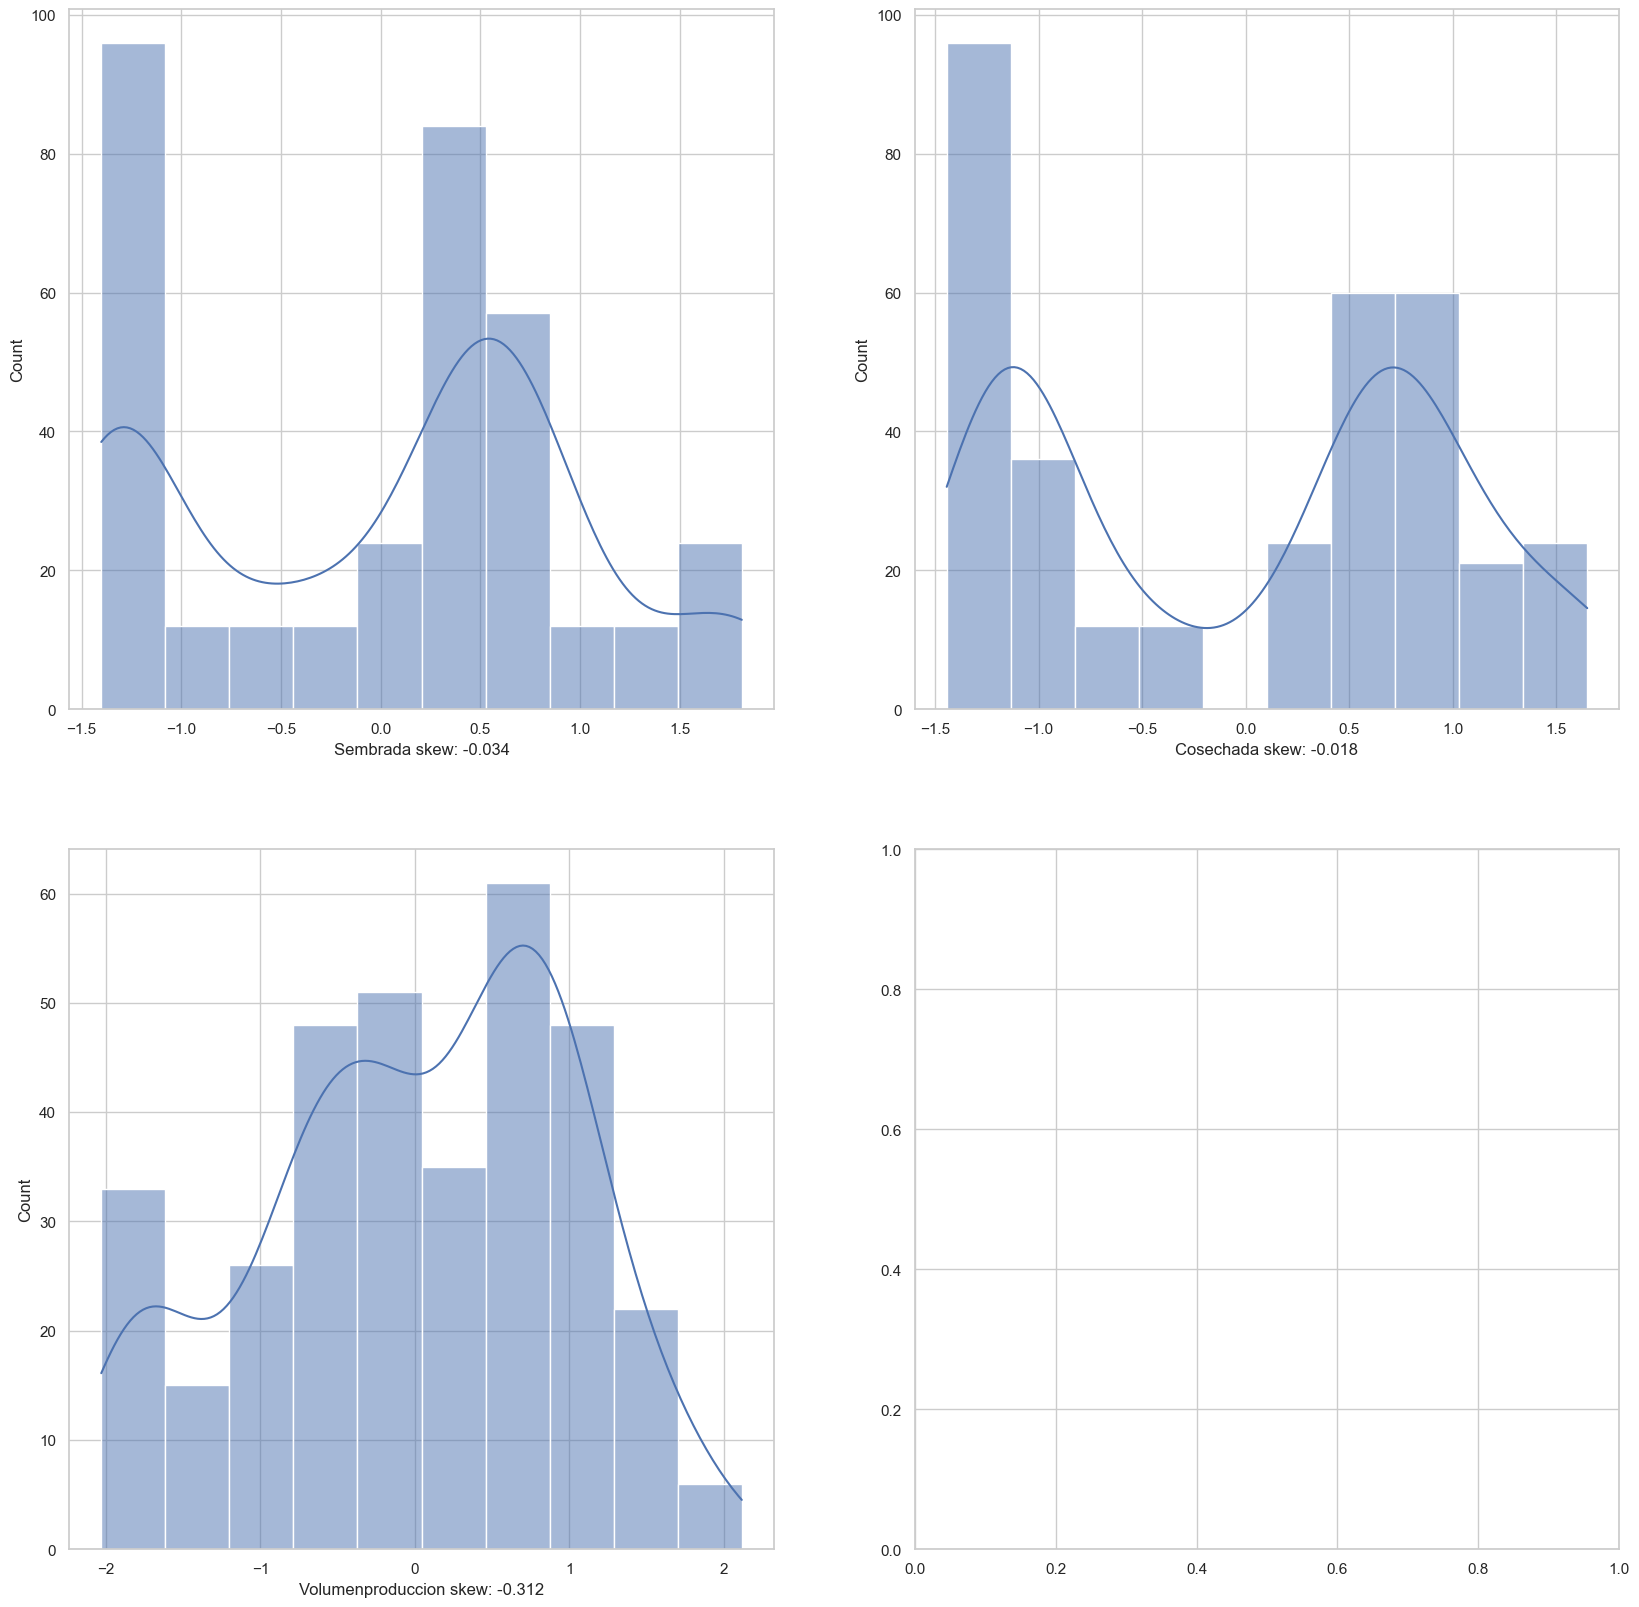

In [37]:
# Aplicar transformación Box-Cox y graficar matriz de histogramas con la nueva distribución
figure, axis = plt.subplots(2, 2, figsize = (20, 20))
axis = axis.ravel()
skewed_cols = ['Sembrada', 'Cosechada', 'Volumenproduccion']

for col, ax in zip(skewed_cols, axis):
    df_fe[col] = power_transform(df_fe[[col]], method = 'box-cox')
    skew = round(df_fe[col].skew(), 3)
    sns.histplot(x = df_fe[col], bins = 10, kde = True, ax = ax)
    ax.set(xlabel = f'{col} skew: {skew}')

Como se pueden observar en los histogramas de las variables con asimetría ahora ya corregidos, si bien las variables no logran tener una distribución Gaussiana perfecta, su asimetría sí disminuye significativamente a comparación de como estaban antes. La variable `Sembrada` tenía una asimetría de 0.556, y ahora fue reducida a -0.135. La variable `Cosechada` tenía una asimetría de 0.767 y ahora fue reducida a -0.064, por lo que prácticamente dejó de tener asimetría. La variable `Volumenproduccion` tenía una asimetría de 0.941 y ahora fue reducida a -0.215.

Ahora teniendo variables numéricas con una distribución más Gaussiana, se puede proceder a trabajar ahora con el otro tipo de variables, las variables categóricas. Para que estas puedan ser empleadas para el modelo, tendrán que ser codificadas.

#### 5.5 Codificación y variables temporales

Las variables categóricas y temporales se transforman a representaciones numéricas adecuadas para su uso en modelos de aprendizaje automático y series de tiempo, incorporando información explícita sobre modalidad de producción y estacionalidad mensual.

En este caso, la variable `Mes` contiene el número del mes al que corresponde el registro. Si bien se podría simplemente aplicar una Codificación Ordinal, esto respetaría el orden de los meses, pero también provocaría que el 1 (Enero) parezca el más lejano al 12 (Diciembre), cuando en la realidad Diciembre precede a Enero (12 precede al 1). Para poder representar más adecuadamente este comportamiento, se decidió emplear una `Codificación Cíclica`, el cual justamente respeta esta continuidad a través de coordenadas calculadas por medio de transformaciones de seno y coseno para poder ubicar el mes como un punto en un círculo. [[5]](#ref5) [[6]](#ref6)

In [38]:
# Transformadores seno y coseno para codificación cíclica
df_fe["Mes_Sin"] = np.sin(2 * np.pi * df_fe["Mes"] / 12)
df_fe["Mes_Cos"] = np.cos(2 * np.pi * df_fe["Mes"] / 12)
df_fe.head()

,Anio,Mes,Sembrada,Cosechada,Rendimiento,Volumenproduccion,Mes_Sin,Mes_Cos
Fecha,,,,,,,,
1996-01-01,1996,1,-0.85,-1.15,18.40,-0.93,0.50,0.87
1996-02-01,1996,2,-0.85,-1.15,18.40,-0.80,0.87,0.50
1996-03-01,1996,3,-0.85,-1.15,18.40,-0.64,1.00,0.00
1996-04-01,1996,4,-0.85,-1.15,18.40,-0.60,0.87,-0.50
1996-05-01,1996,5,-0.85,-1.15,18.40,-0.46,0.50,-0.87


In [39]:
# Eliminación de variables originales no codificadas
df_fe = df_fe.drop(columns = ['Mes'])
df_fe.head()

,Anio,Sembrada,Cosechada,Rendimiento,Volumenproduccion,Mes_Sin,Mes_Cos
Fecha,,,,,,,
1996-01-01,1996,-0.85,-1.15,18.40,-0.93,0.50,0.87
1996-02-01,1996,-0.85,-1.15,18.40,-0.80,0.87,0.50
1996-03-01,1996,-0.85,-1.15,18.40,-0.64,1.00,0.00
1996-04-01,1996,-0.85,-1.15,18.40,-0.60,0.87,-0.50
1996-05-01,1996,-0.85,-1.15,18.40,-0.46,0.50,-0.87


#### 5.6 Escalamiento / normalización

Se aplica el escalamiento de las variables numéricas en una versión paralela del dataset, con el objetivo de facilitar su uso en modelos sensibles a la magnitud de las variables, manteniendo al mismo tiempo una versión no escalada para técnicas que no requieren normalización.

Una vez aplicadas las transformaciones necesarias para corregir asimetrías en las variables numéricas y codificar las variables categóricas y temporales, ya se cuenta con un dataset compuesto completamente por variables numéricas. En los siguientes histogramas es posible visualizar la escala y distribución de todas las variables numéricas dentro del dataset.

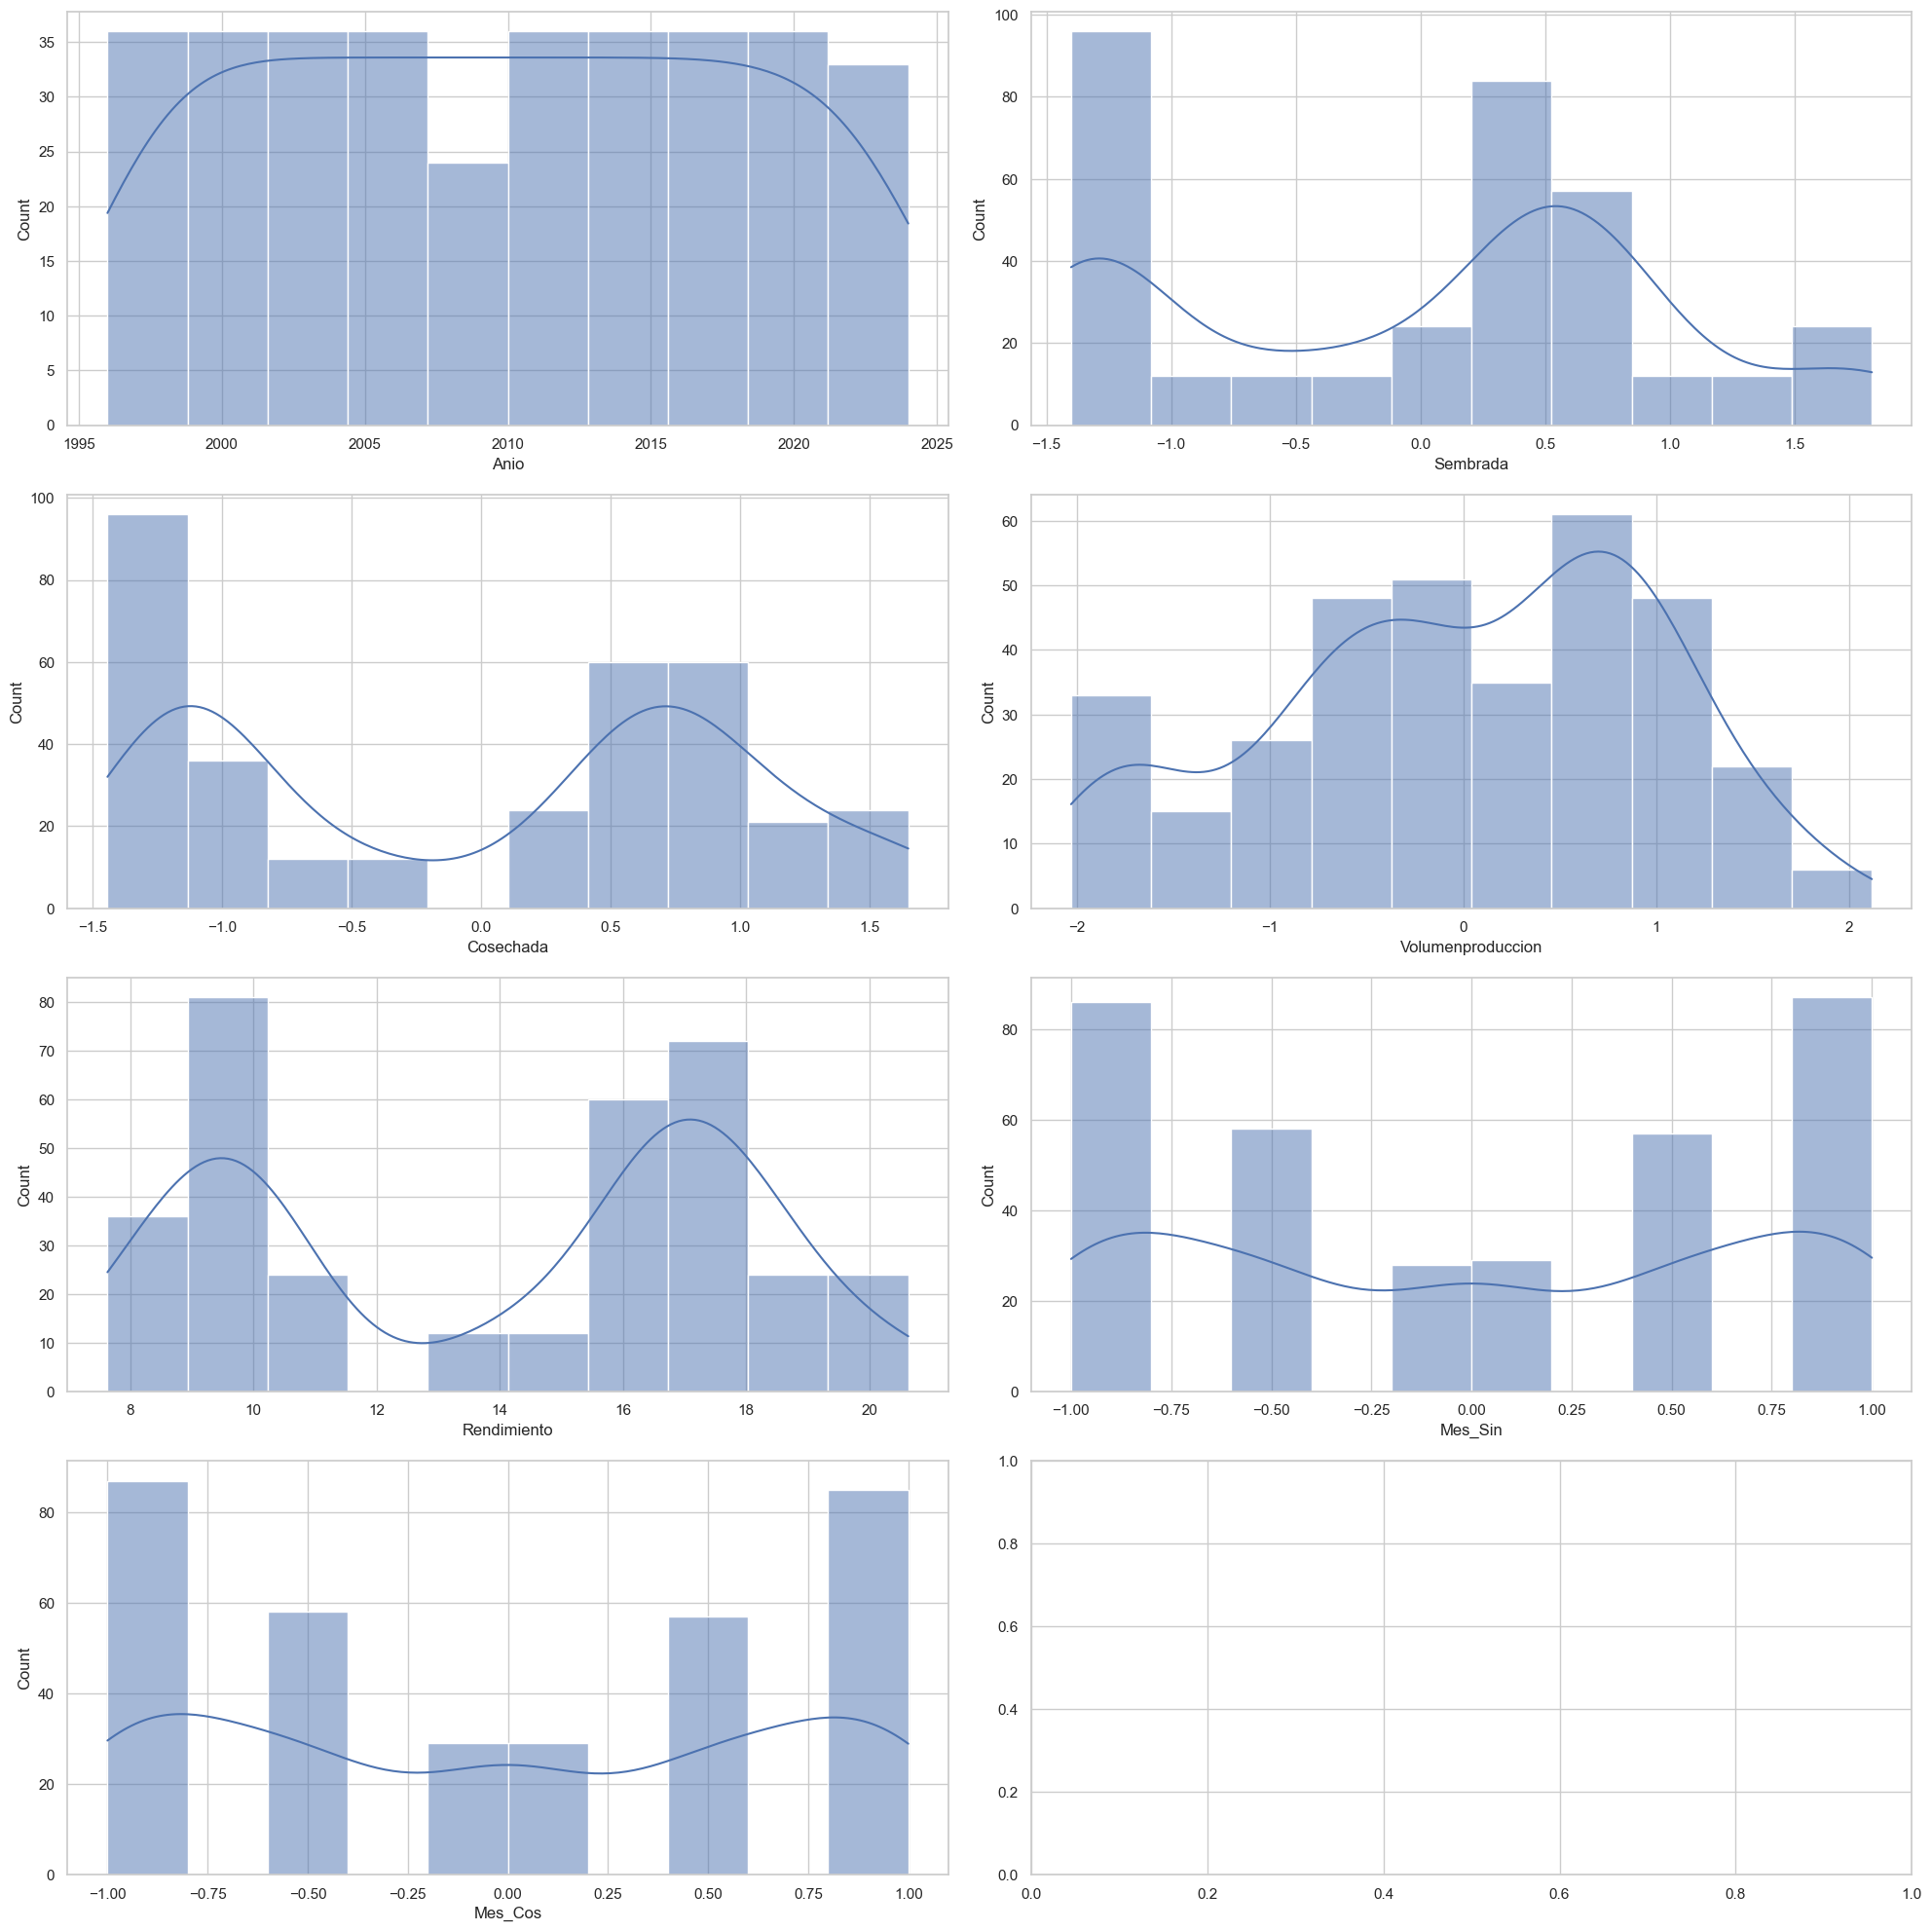

In [40]:
# Variables numéricas del dataset
num_cols = [ "Anio", "Sembrada", "Cosechada", "Volumenproduccion", "Rendimiento", "Mes_Sin", "Mes_Cos"]

# Histogramas con variables numéricas
figure, axis = plt.subplots(4, 2, figsize=(20,20))
axis = axis.ravel()

for col, ax in zip(num_cols, axis):
    sns.histplot(x=df_fe[col], bins=10, kde=True, ax=ax)
    ax.set(xlabel=col)

plt.tight_layout()
plt.show()


En los histogramas anteriores se observa que no existen asimetrías por lo que una normalización de tipo 'MinMax' resulta adecuada, ya que preserva la forma original de las distribuciones y únicamente ajusta su escala a un rango entre 0 y 1. Esta técnica en comparación con otros tipos, como estandarización o Robusto, busca conservar la estructura de los datos, permitiendo mantener la proporción con los valores originales.

No obstante, se identifica que no todas las variables gráficas requieren este tipo de normalización. Tal es el caso de la variable `Nommodalidad_one_hot`, la cual debido a su codificación binaria, ya se encuentra en un rango entre 0 y 1 por lo que no es necesario aplicarle una transformación adicional.


Por otro lado, la variable `Anio`, que no contaba con una transformación previa, también se normaliza mediante la técnica 'MinMax' con el objetivo de homogeneizar su escala con respecto a las demás variables y evitar que su magnitud influya sobre el modelo.

Finalmente, las variables de `Men_Sin` y `Mes_Cos`, que si bien presentan una escala más reducida y cercana al rango propuesto por 'MinMax', también son normalizadas con el fin de mantener consistencia entre todas las variables numéricas del dataset.


El resto de las variables numéricas se normalizaron de manera directa, asegurando una escala homogénea entre todas las variables.

In [41]:
from sklearn.preprocessing import MinMaxScaler

num_cols_escal = ["Anio","Sembrada","Cosechada","Volumenproduccion","Rendimiento","Mes_Sin","Mes_Cos",]

# Aplicación de normalización MinMax al dataset después de las transformaciones
scaler = MinMaxScaler()
df_fe[num_cols_escal] = scaler.fit_transform(df_fe[num_cols_escal])


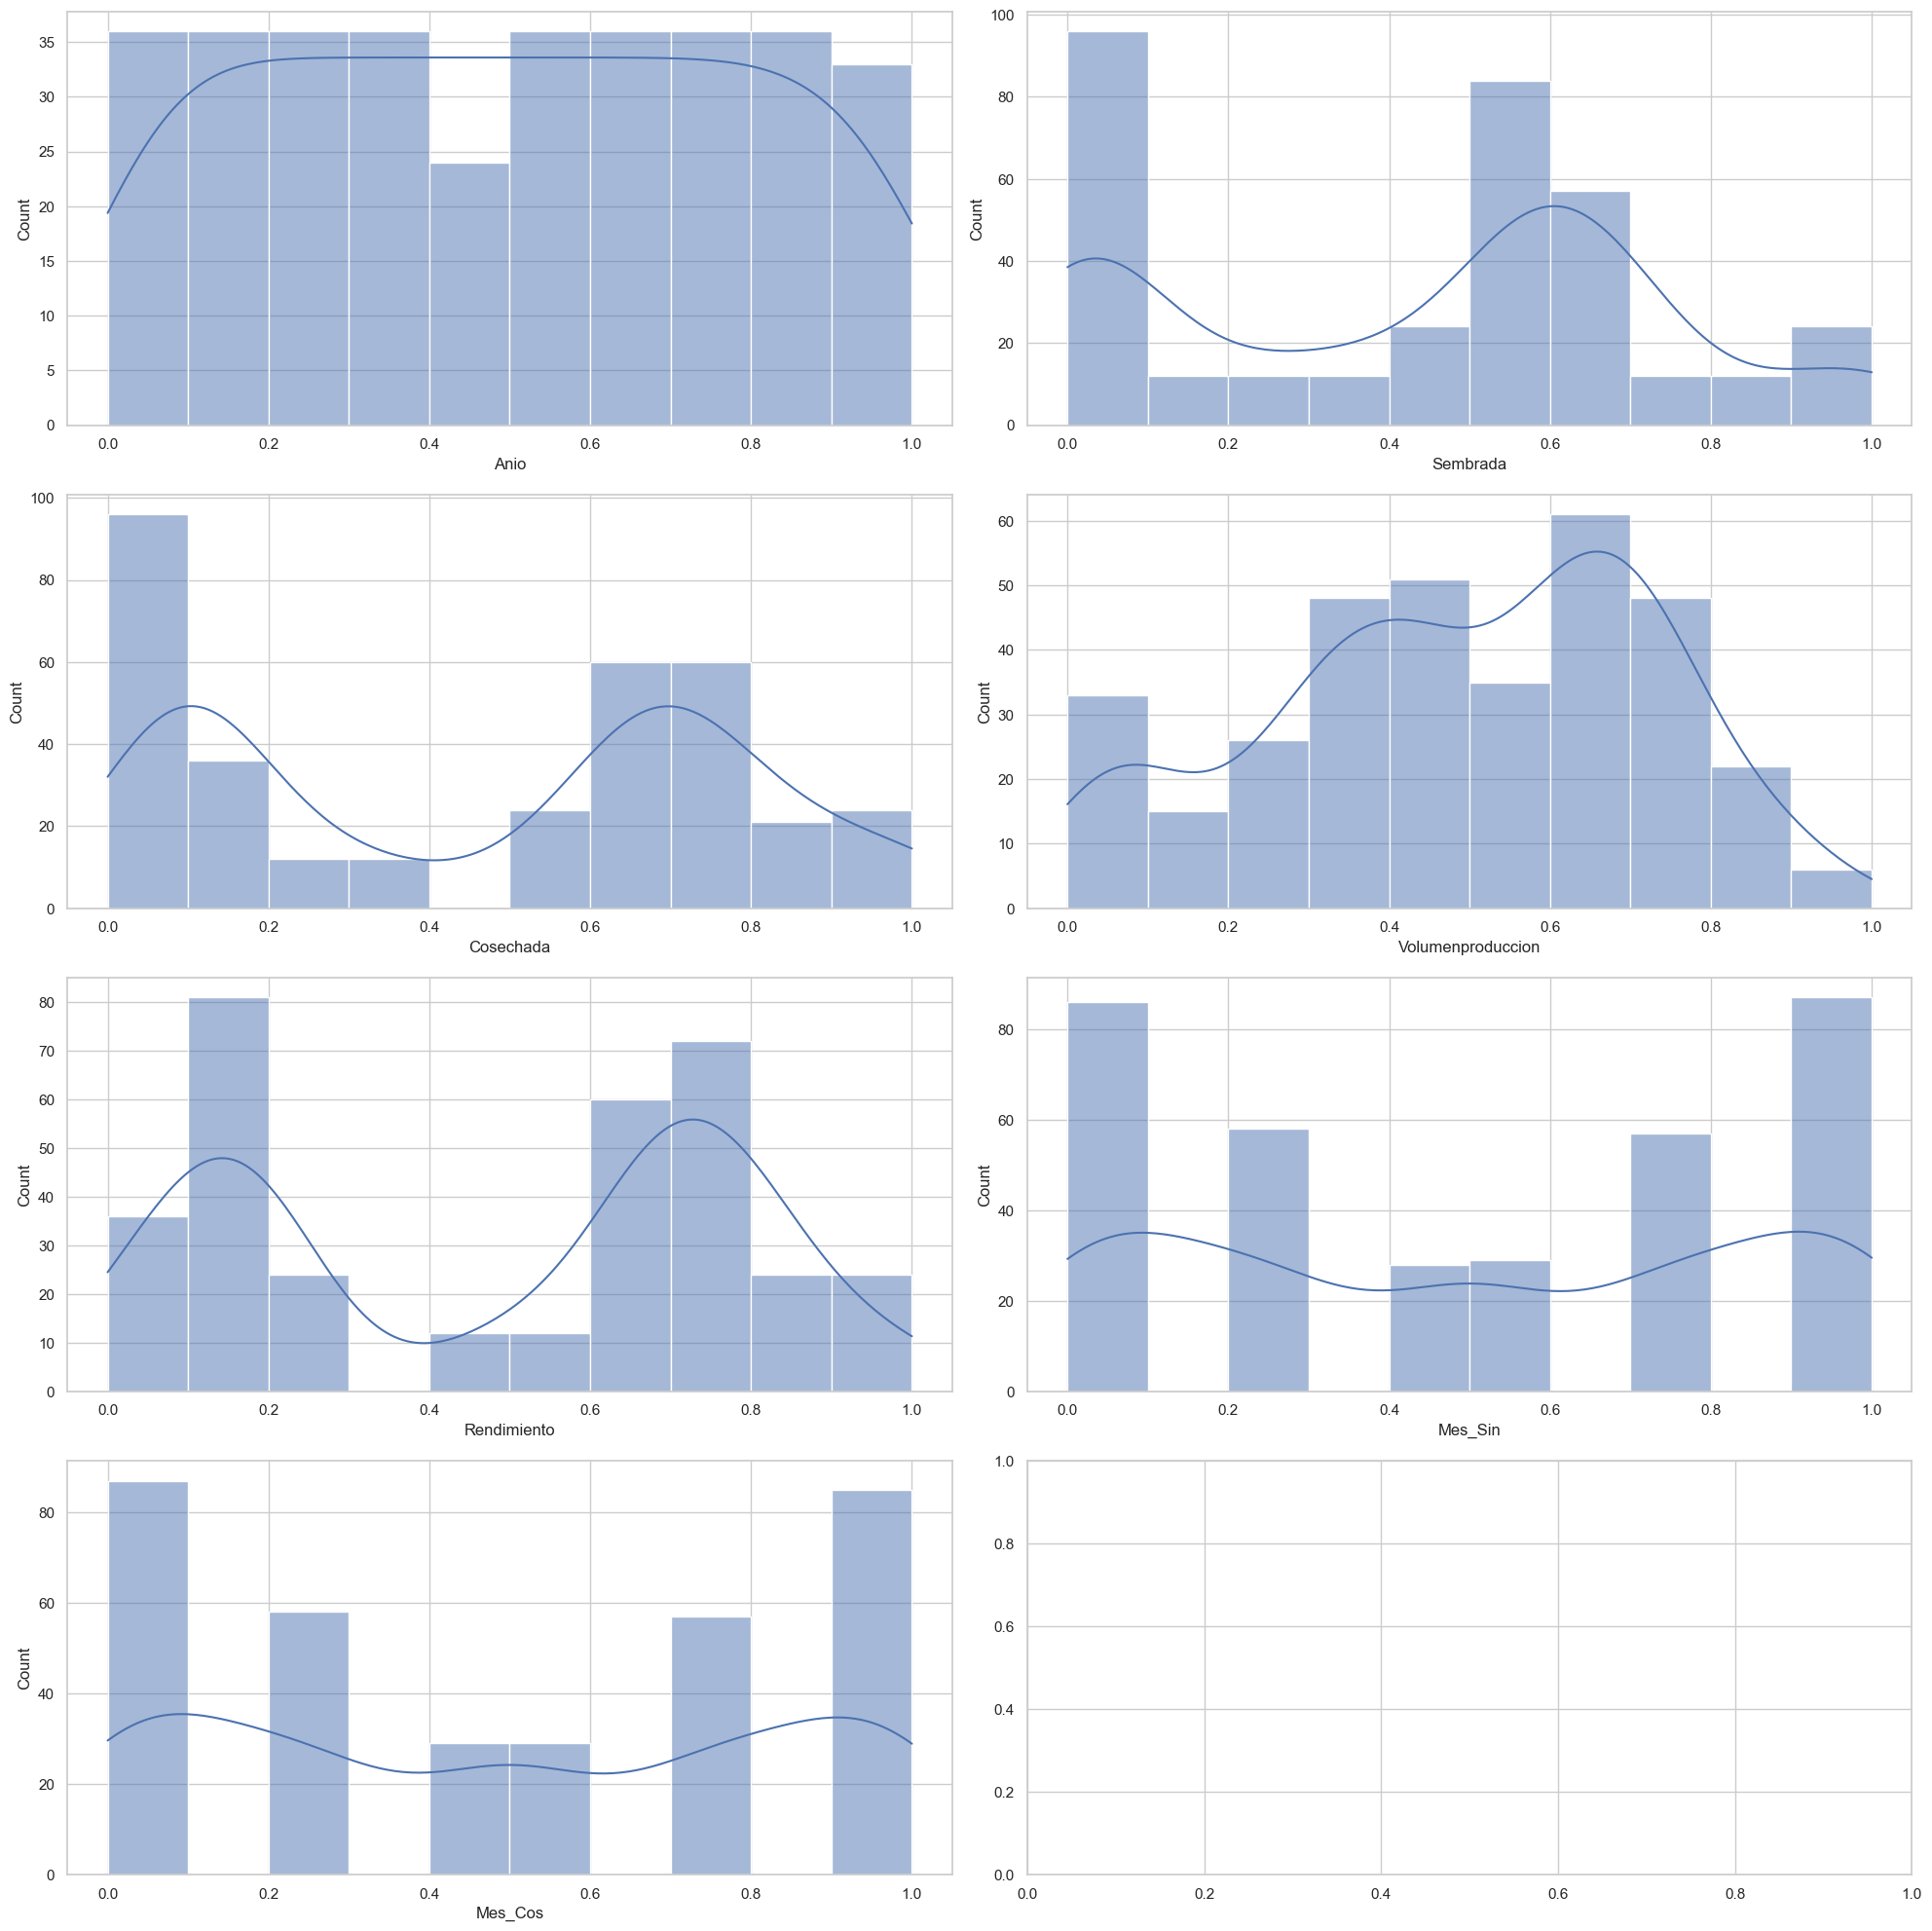

In [42]:
figure, axis = plt.subplots(4, 2, figsize=(20,20))
axis = axis.ravel()

# Histogramas de varaibles numéricas con transformación y normalización
for col, ax in zip(num_cols_escal, axis):
    sns.histplot(x=df_fe[col], bins=10, kde=True, ax=ax)
    ax.set(xlabel=col)

plt.tight_layout()
plt.show()


Tras la aplicación de la normalización, en los histogramas generados se puede observar que las variables numéricas quedan reescaladas en un rango entre 0 y 1, permitiendo su uso en etapas futuras del modelado.

### <a class="anchor" id="reduccion">6. Selección y reducción de características</a>

En esta sección se evalúa la relevancia, redundancia y estabilidad de las características generadas en etapas previas, mediante análisis de correlación, criterios estadísticos y consideraciones de interpretabilidad, con el objetivo de definir el conjunto final de variables a utilizar en los modelos predictivos. A diferencia de la [sección 5](#ingenieria), en esta etapa no se crean nuevas variables, sino que se seleccionan aquellas que aportan mayor valor explicativo al problema y, en su caso, se reducen.

#### 6.1 Revisión de varianza y consistencia de las variables

En este punto se analiza la variabilidad de las características numéricas con el fin de identificar variables con varianza nula o casi nula, las cuales no aportan información útil al proceso de modelado y pueden ser eliminadas sin pérdida de capacidad explicativa.

In [43]:
from sklearn.feature_selection import VarianceThreshold

# Separar "X" y "y"
y = df_fe["Volumenproduccion"]
X = df_fe.drop(columns=["Volumenproduccion"])

# Umbral de varianza (0 elimina columnas constantes)
var_selector = VarianceThreshold(threshold=0.0)
X_var = var_selector.fit_transform(X)

# Columnas conservadas
cols_var = X.columns[var_selector.get_support()]

X_var = pd.DataFrame(X_var, columns=cols_var, index=X.index)

X_var.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 345 entries, 1996-01-01 to 2024-12-01
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Anio         345 non-null    float64
 1   Sembrada     345 non-null    float64
 2   Cosechada    345 non-null    float64
 3   Rendimiento  345 non-null    float64
 4   Mes_Sin      345 non-null    float64
 5   Mes_Cos      345 non-null    float64
dtypes: float64(6)
memory usage: 18.9 KB


En este apartado se evaluó la variabilidad de las variables explicativas con el objetivo de identificar características con varianza nula o cercana a cero que no aportaran información al modelo. El análisis mostró que todas las variables presentan una variabilidad adecuada, por lo que **no se eliminó ninguna característica** en esta etapa.

Esta decisión es consistente con el tamaño y naturaleza del dataset, en el cual incluso variables con menor dispersión pueden aportar señales relevantes bajo modelos no lineales o temporales.

#### 6.2 Análisis de correlación y redundancia

En esta etapa, se analiza la correlación entre las variables predictoras y la variable objetivo, así como la correlación entre predictores, con el objetivo de identificar posibles redundancias, multicolinealidad o variables altamente dependientes que puedan afectar la estabilidad de los modelos.

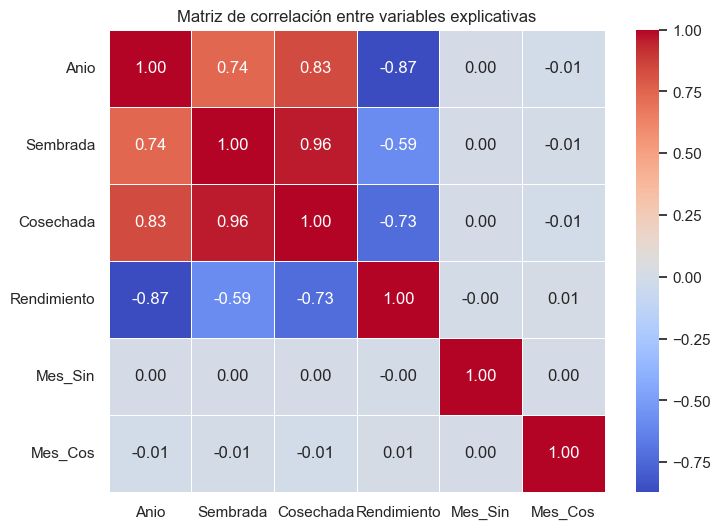

In [44]:
# Matriz de correlación
corr_matrix = X_var.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5
)
plt.title("Matriz de correlación entre variables explicativas")
plt.show()

In [45]:
# Umbral de correlación
corr_threshold = 0.9

# Encontrar pares altamente correlacionados
high_corr = (
    corr_matrix
    .abs()
    .where(lambda x: x > corr_threshold)
    .stack()
    .reset_index()
)

high_corr.columns = ["Variable_1", "Variable_2", "Correlacion"]

# Eliminar autocorrelaciones
high_corr = high_corr[high_corr["Variable_1"] != high_corr["Variable_2"]]

high_corr

,Variable_1,Variable_2,Correlacion
2,Sembrada,Cosechada,0.96
3,Cosechada,Sembrada,0.96


En esta etapa, se analizó la matriz de correlación entre las variables explicativas para identificar posibles problemas de colinealidad. Se observó una **alta correlación entre las variables `Sembrada` y `Cosechada`**, lo cual es esperable dada su relación productiva directa.

A pesar de esta colinealidad, ambas variables se conservaron debido a su **interpretabilidad agronómica** y a que pueden capturar dinámicas distintas en modelos no lineales. El resto de las variables no presenta correlaciones significativas entre sí, lo que reduce el riesgo de redundancia en el conjunto de características.

#### 6.3 Evaluación de variables temporales y categóricas

En esta sección se analiza la representación de las variables temporales y categóricas del conjunto de datos, evaluando su contribución informativa y la forma en que capturan patrones estacionales y estructurales relevantes para el modelado de la oferta productiva.

In [46]:
X_var.describe().T

,count,mean,std,min,25%,50%,75%,max
Anio,345.00,0.50,0.30,0.00,0.25,0.50,0.75,1.00
Sembrada,345.00,0.44,0.31,0.00,0.07,0.55,0.67,1.00
Cosechada,345.00,0.47,0.32,0.00,0.10,0.57,0.70,1.00
Rendimiento,345.00,0.48,0.31,0.00,0.17,0.64,0.73,1.00
Mes_Sin,345.00,0.50,0.35,0.00,0.25,0.50,0.93,1.00
Mes_Cos,345.00,0.50,0.35,0.00,0.07,0.50,0.75,1.00


El análisis estadístico descriptivo muestra que las variables se encuentran correctamente escaladas tras el proceso de normalización aplicado en etapas previas y presentan distribuciones estables, sin valores extremos anómalos ni concentraciones degeneradas. Las variables temporales codificadas mediante funciones seno y coseno (`Mes_Sin`, `Mes_Cos`) muestran un comportamiento uniforme, lo que indica una adecuada representación de la estacionalidad y continuidad temporal del ciclo anual.

Asimismo, la variable categórica codificada (`Nommodalidad_one_hot`) presenta una distribución binaria consistente, aunque con presencia de valores faltantes que deberán ser tratados durante la preparación del conjunto de entrenamiento para los modelos predictivos.

#### 6.4 Consideraciones sobre reducción dimensional (PCA)

En esta subsección se explora de manera diagnóstica el uso del Análisis de Componentes Principales (PCA) como técnica de reducción de dimensionalidad, con el objetivo de evaluar el grado de redundancia entre las variables explicativas y la posible concentración de la varianza en un número reducido de componentes.

In [47]:
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Imputación simple solo para PCA (Nommodalidad_one_hot contiene valores faltantes)
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)

# Escalamiento (recomendado para PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

pca = PCA()
pca.fit(X_scaled)

explained_variance = np.cumsum(pca.explained_variance_ratio_)
explained_variance

array([0.5608828 , 0.72755035, 0.89418393, 0.97858514, 0.9964308 ,
       1.        ])

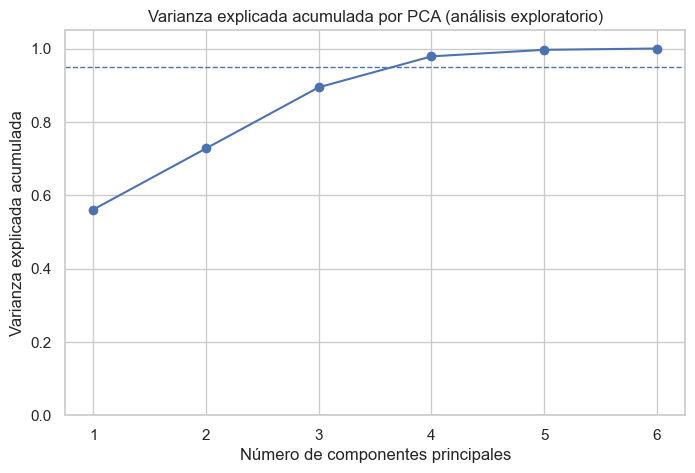

In [48]:
# Gráfica
plt.figure(figsize=(8, 5))
plt.plot(
    range(1, len(explained_variance) + 1),
    explained_variance,
    marker='o'
)

# Umbral del 95%
plt.axhline(
    y=0.95,
    linestyle='--',
    linewidth=1
)

plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza explicada acumulada')
plt.title('Varianza explicada acumulada por PCA (análisis exploratorio)')
plt.xticks(range(1, len(explained_variance) + 1))
plt.ylim(0, 1.05)
plt.grid(True)

plt.show()

De manera exploratoria, se ejecutó un Análisis de Componentes Principales (PCA) sobre las variables previamente escaladas, con el fin de evaluar la posible reducción de dimensionalidad y la estructura latente del conjunto de características. Los resultados muestran que las primeras cuatro componentes explican aproximadamente el 84% de la varianza acumulada, mientras que seis componentes concentran más del 97% de la varianza total.

Aunque el escalamiento modifica la contribución relativa de cada variable a las componentes principales, el análisis confirma que la información se encuentra distribuida entre un número reducido de dimensiones.

No obstante, dado el bajo número de variables, la necesidad de mantener interpretabilidad y el hecho de que la reducción de dimensionalidad no aporta una ventaja clara en términos de complejidad o desempeño en esta etapa, se decidió **no incorporar PCA** en el conjunto final de características, reservando su uso únicamente como herramienta diagnóstica.

#### 6.5 Consideraciones sobre técnicas no aplicadas

Si bien la rúbrica contempla el uso de técnicas como **Chi-cuadrado**, **ANOVA** y **Análisis Factorial**, estas no se aplican en el presente estudio debido a la naturaleza de los datos y del problema abordado.

- La prueba de Chi-cuadrado se utiliza principalmente en problemas de clasificación y análisis de dependencia entre variables categóricas, por lo que no resulta adecuada en este caso, donde la variable objetivo (Volumenproduccion) es continua.
- El análisis ANOVA es más pertinente cuando se comparan medias entre múltiples grupos categóricos bien definidos; sin embargo, en este conjunto de datos solo existe una variable categórica binaria ya codificada y su efecto se evalúa de forma más directa mediante modelos de regresión.
- El Análisis Factorial se descarta debido al bajo número de variables disponibles y a la ausencia de un marco teórico que justifique la existencia de factores latentes subyacentes, además de que su aplicación podría reducir la interpretabilidad de los resultados, un aspecto clave para el análisis de la oferta productiva.

#### 6.6 Resultado final del conjunto de características

In [49]:
X_final = X_var.copy()

X_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 345 entries, 1996-01-01 to 2024-12-01
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Anio         345 non-null    float64
 1   Sembrada     345 non-null    float64
 2   Cosechada    345 non-null    float64
 3   Rendimiento  345 non-null    float64
 4   Mes_Sin      345 non-null    float64
 5   Mes_Cos      345 non-null    float64
dtypes: float64(6)
memory usage: 18.9 KB


**`NOTA`**: La imputación de valores faltantes se realizará posteriormente dentro de pipelines de modelado, utilizando únicamente información del conjunto de entrenamiento, con el fin de evitar fuga de información hacia los modelos predictivos.

#### 6.7 Exportación de conjuntos de datos

Con el fin de asegurar la trazabilidad, reproducibilidad y separación clara entre las fases de preparación de datos y modelado, el conjunto final de variables explicativas (`X_final`) y la variable objetivo (`y`) se exportan a archivos independientes. Estos archivos constituyen la entrada oficial para la fase de modelado, evitando re-ejecuciones innecesarias de la ingeniería de características y reduciendo el riesgo de inconsistencias entre notebooks.

In [50]:
# Guardar DataFrame maestro a CSV
y_final = y.copy()

# Exportar variables explicativas
X_final.reset_index().to_csv(
    PROCESSED_DATA_DIR / "X_final_mensual.csv",
    index=False
)

# Exportar variable objetivo
y_final.reset_index().to_csv(
    PROCESSED_DATA_DIR / "y_mensual.csv",
    index=False
)

En conclusión, tras aplicar criterios de varianza, correlación y análisis exploratorio, se decidió conservar el conjunto completo de variables seleccionadas en la fase de ingeniería de características. **No se aplicaron técnicas de reducción dimensional como PCA o FA debido a la necesidad de mantener interpretabilidad y coherencia agronómica, así como a la baja dimensionalidad del dataset**. Estas decisiones aseguran un equilibrio adecuado entre simplicidad, explicabilidad y capacidad predictiva para las etapas posteriores de modelado.

### <a class="anchor" id="conclusiones">Conclusiones</a>

Durante la fase de preparación de los datos se llevó a cabo un proceso sistemático de limpieza, depuración, transformación y selección de características, con el objetivo de construir un conjunto de variables consistente, interpretable y adecuado para el modelado predictivo del volumen de producción.

Se eliminaron variables que introducían riesgo de fuga de información o que no serían observables en un escenario real de predicción, privilegiando características productivas y temporales con sentido agronómico. Asimismo, se incorporaron transformaciones temporales que permiten capturar patrones estacionales de manera continua, evitando la imposición de discontinuidades artificiales en el tiempo.

Adicionalmente, se evaluó la implementación de discretización sobre las variables numéricas, sin embargo, al tratarse de un problema de regresión enfocado a la predicción de la oferta productiva, se optó por conservar las variables en formato continuo, con el fin de conservar las relaciones cuantitativas. Por otro lado, se implementó la normalización MinMax sobre las variables numéricas para homogeneizar la escala del dataset, facilitando su uso en modelos sensibles a la magnitud de las variables sin comprometer la estructura original de las distribuciones.

El análisis de correlación y varianza mostró que las variables conservadas aportan información complementaria, y que la colinealidad observada responde a relaciones estructurales propias del proceso productivo. Por esta razón, dichas variables se preservaron por criterios de interpretabilidad y por su potencial utilidad en modelos no lineales.

Finalmente, se exploraron técnicas de reducción de dimensionalidad con fines diagnósticos, concluyendo que, dado el bajo número de variables y la importancia de mantener la interpretabilidad del modelo, no resulta necesario aplicar una reducción adicional en esta etapa. Con ello, el conjunto final de características queda preparado para la fase de modelado, cumpliendo los principios de la metodología CRISP-ML en términos de calidad, coherencia y alineación con los objetivos del proyecto.

### <a class="anchor" id="ref">Referencias</a>

[<a class="anchor" id="ref1">1</a>] Secretaría de Agricultura y Desarrollo Rural, “Cierre agrícola,” *AGRICULTURA*, s.f. [En línea].
Disponible en: https://nube.agricultura.gob.mx/cierre_agricola/. Accedido: 26-ene.-2026.

[<a class="anchor" id="ref2">2</a>] Secretaría de Agricultura y Desarrollo Rural, “Datos abiertos del sector agrícola,” *AGRICULTURA*, s.f.
[En línea]. Disponible en: https://nube.agricultura.gob.mx/datosAbiertos/Agricola.php. Accedido: 26-
ene.-2026.

[<a class="anchor" id="ref3">3</a>] United States International Trade Commission (USITC), “DataWeb: Importaciones generales por HTS,” *USITC*, s. f. [En línea]. Disponible en: https://dataweb.usitc.gov/trade/search/GenImp/HTS. Accedido: 28-ene.-2026.

[<a class="anchor" id="ref4">4</a>]  *S. Galli, Python Feature Engineering Cookbook: Over 70 recipes for creating, engineering, and transforming features to build machine learning models*, 2nd ed. Birmingham, UK: Packt Publishing, 2022.

[<a class="anchor" id="ref5">5</a>] Towards Data Science, “Codificación cíclica: una alternativa a la codificación *one-hot* para características de series temporales,” *Towards Data Science*, s. f. \[En línea]. Disponible en: <https://towardsdatascience.com/cyclical-encoding-an-alternative-to-one-hot-encoding-for-time-series-features-4db46248ebba/>. Accedido: 7-feb.-2026.

[<a class="anchor" id="ref6">6</a>] R. J. Hyndman y G. Athanasopoulos, “Predictores útiles: series de Fourier,” *Forecasting: Principles and Practice (3rd ed.)*, OTexts, s. f. \[En línea]. Disponible en: <https://otexts.com/fpp3/useful-predictors.html#fourier-series>. Accedido: 7-feb.-2026.